In [1]:
import numpy as np
import uproot
import awkward as ak
import awkward0
import matplotlib.pyplot as plt
import math
import pandas as pd
import ROOT
from copy import deepcopy
import uproot3_methods
from uproot3_methods import TLorentzVectorArray, TLorentzVector
from bbtautau_helpers import Selection, Sample, eff_sens_plots, create_p4s_branch, DiTauEfficiencyTracker, chosen_boosted_eletau_efficiencies, chosen_boosted_mutau_efficiencies, chosen_boosted_eletau_rundown, \
                                calculate_chosen_truth_efficiencies, choose_boosted_eletau_event, nearest_candidate_to_anchor, create_normed_hist, create_eff_histograms, \
                                eff_hist_lists, norm_hist_weights, resolved_selection
from analysis_samples import sig10_sample as sig10_sample, sig16_sample, sig20_sample, ttbar_sample, zhf_sample, signal_samples, background_samples, all_samples
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/persist.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  {"minsize": 8192, "types": [numpy.bool_, numpy.bool, numpy.integer

Welcome to JupyROOT 6.26/08
Information not supplied to calculate MC weight
Information not supplied to calculate MC weight


In [2]:
for sample in all_samples:
    print(sample)

Sample: 1 TeV
Sourced from: ../samples/450522_X1000_bbtautau_lephad.DAOD_HIGGBOOSTEDLH.V0.ntuple.root
Events: 72278
Source events: 100000
MC weight: 0.0023053113859999998

Sample: 1.6 TeV
Sourced from: ../samples/450166_X1600_bbtautau_lephad.DAOD_HIGGBOOSTEDLH.V0.ntuple.root
Events: 114567
Source events: 130000
MC weight: 0.0017733164507692306

Sample: 2 TeV
Sourced from: ../samples/450524_X2000_bbtautau_lephad.DAOD_HIGGBOOSTEDLH.V0.ntuple.root
Events: 53826
Source events: 60000
MC weight: 0.003974893344999999

Sample: Z+jets
Sourced from: ../samples/364139_Ztautau_BFilter.DAOD_HIGGBOOSTEDLH.V1.ntuple.root
Events: 18148
Source events: 490000
MC weight: 0.4339286114285714

Sample: ttbar
Sourced from: ../samples/410470_ttbar_nonallhad.DAOD_HIGGBOOSTEDLH.V1.ntuple.root
Events: 56447
Source events: 1480000
MC weight: 37.28679695945945

Sample: W+jets_taunu
Sourced from: ../samples/364195_Wtaunu_MAXHTPTV280_500.DAOD_HIGGBOOSTEDLH.TEST0.ntuple.root
Events: 2601
Source events: 200000
MC weigh

### Functions

In [8]:
def object_mask(branches, branch_name):
    nobjects = branches[f'N{branch_name}']
    mask = nobjects > 0
    return mask

def object_efficiency(branches, branch_name):
    mask = object_mask(branches, branch_name)
    return sum(mask) / len(branches)

def branch_drs(branches, first_name, second_name):
    first_p4s = create_p4s_branch(branches, first_name)
    second_p4s = create_p4s_branch(branches, second_name)
    drs = first_p4s.delta_r(second_p4s)
    return drs

def get_tm_mask(branches, reco_name, truth_name, max_dr):
    drs = branch_drs(branches, reco_name, truth_name)
    mask = drs < max_dr
    return mask

def get_tm_event_mask(branches, reco_name, truth_name, max_dr):
    object_mask = get_tm_mask(branches, reco_name, truth_name, max_dr)
    event_mask = ak.any(object_mask, axis=1)
    return event_mask

def truthmatch_branch(branches, reco_name, truth_name, max_dr):
    reco_p4s = create_p4s_branch(branches, reco_name)
    mask = get_tm_mask(branches, reco_name, truth_name, max_dr)
    matched_reco_p4s = reco_p4s[mask]
    return matched_reco_p4s

def eff_truthmatch_branch(branches, reco_name, truth_name, max_dr):
    tm_mask = get_tm_event_mask(branches, reco_name, truth_name, max_dr)
    return sum(tm_mask) / len(branches)

def leading_reco_is_tm_mask(branches, reco_name, truth_name, max_dr):
    event_mask = get_tm_event_mask(branches, reco_name, truth_name, max_dr)
    reco_pt_name = '{}Pt'.format(reco_name)
    masked_pts = branches[reco_pt_name][event_mask]
    leading_reco_pts = np.array([max(pts) for pts in masked_pts if len(pts) > 0])
    object_mask = get_tm_mask(branches, reco_name, truth_name, max_dr)
    tm_reco_pts = branches[reco_pt_name][object_mask]
    # There may be multiple TM reco objects, so choose the leading
    tm_reco_pts = np.array([max(pts) for pts in tm_reco_pts if len(pts) > 0])
    mask = np.equal(tm_reco_pts, leading_reco_pts)
    return mask
    
def num_leading_reco_is_tm(branches, reco_name, truth_name, max_dr):
    mask = leading_reco_is_tm_mask(branches, reco_name, truth_name, max_dr)
    count = sum(mask)
    return count

def frac_leading_reco_close_to_truth(branches, reco_name, truth_name, max_dr):
    leading_tm_count = num_leading_reco_is_tm(branches, reco_name, truth_name, max_dr)
    nevents = len(branches)
    frac = leading_tm_count / nevents
    return frac    

def frac_tm_is_leading_reco(branches, reco_name, truth_name, max_dr):
    leading_tm_count = num_leading_reco_is_tm(branches, reco_name, truth_name, max_dr)
    tm_count = sum(get_tm_event_mask(branches, reco_name, truth_name, max_dr))
    frac = leading_tm_count / tm_count
    return frac

In [9]:
def get_tau_chosen_p4s(branches, min_dr=0):
    indices = get_chosen_dr_index(branches, min_dr)
    min_pts = [pts[index] for pts, index in zip(branches['TauPt'], indices) if index is not None]
    min_etas = [etas[index] for etas, index in zip(branches['TauEta'], indices) if index is not None]
    min_phis = [phis[index] for phis, index in zip(branches['TauPhi'], indices) if index is not None]
    min_es = [es[index] for es, index in zip(branches['TauE'], indices) if index is not None]
    p4s = TLorentzVectorArray.from_ptetaphie(min_pts, min_etas, min_phis, min_es)
    return p4s

# B-tagged jets
def truth_btag_drs(branches):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    drs = truth_b_p4s.delta_r(truth_antib_p4s)
    return drs
    
def btag_efficiency(branches):
    btag_p4s = create_p4s_branch(branches, 'BTagJet')
    btag_mask = [1 if len(p4s) > 0 else 0 for p4s in btag_p4s]
    return sum(btag_mask) / len(btag_p4s)

def get_b_drs(branches):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    all_btag_p4s = create_p4s_branch(branches, 'BTagJet')
    all_b_drs = all_btag_p4s.delta_r(truth_b_p4s)
    return all_b_drs

def get_antib_drs(branches):
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    all_btag_p4s = create_p4s_branch(branches, 'BTagJet')
    all_antib_drs = all_btag_p4s.delta_r(truth_antib_p4s)
    return all_antib_drs

def get_min_b_dr(branches):
    all_b_drs = get_b_drs(branches)
    min_b_dr = [min(drs) if len(drs) > 0 else 10 for drs in all_b_drs]
    return min_b_dr

def get_min_antib_dr(branches):
    all_antib_drs = get_antib_drs(branches)
    min_antib_dr = [min(drs) if len(drs) > 0 else 10 for drs in all_antib_drs]
    return min_antib_dr

def get_frac_bs_close_to_truth(branches):
    min_b_dr = get_min_b_dr(branches)
    min_antib_dr = get_min_antib_dr(branches)
    close_by_b_mask = np.array(min_b_dr) < 0.1
    close_by_antib_mask = np.array(min_antib_dr) < 0.1
    close_by_masks = [close_by_b_mask, close_by_antib_mask]
    close_by_both_mask = ak.all(close_by_masks, 0)
    close_by_either_mask = ak.any(close_by_masks, 0)
    fraction_b_close_by = sum(close_by_b_mask) / len(branches)
    fraction_antib_close_by = sum(close_by_antib_mask) / len(branches)
    fraction_both_close_by = sum(close_by_both_mask) / len(branches)
    fraction_either_close_by = sum(close_by_either_mask) / len(branches)
    return fraction_b_close_by, fraction_antib_close_by, fraction_either_close_by, fraction_both_close_by

def get_frac_leading_btag_close_to_truth(branches, max_dr):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    leading_btag_p4s = create_p4s_branch(branches, 'LeadingBTagJet')
    btag_b_drs = truth_b_p4s.delta_r(leading_btag_p4s)
    btag_antib_drs = truth_antib_p4s.delta_r(leading_btag_p4s)
    close_by_b_mask = btag_b_drs < max_dr
    close_by_antib_mask = btag_antib_drs < max_dr
    close_by_masks = [close_by_b_mask, close_by_antib_mask]
    close_by_either_mask = ak.any(close_by_masks, 0)
    fraction_either_close_by = sum(close_by_either_mask) / len(branches)
    return fraction_either_close_by

def get_frac_leading_jet_close_to_truth(branches, max_dr):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    leading_jet_p4s = create_p4s_branch(branches, 'LeadingJet')
    jet_b_drs = truth_b_p4s.delta_r(leading_jet_p4s)
    jet_antib_drs = truth_antib_p4s.delta_r(leading_jet_p4s)
    close_by_b_mask = jet_b_drs < max_dr
    close_by_antib_mask = jet_antib_drs < max_dr
    close_by_masks = [close_by_b_mask, close_by_antib_mask]
    close_by_either_mask = ak.any(close_by_masks, 0)
    fraction_either_close_by = sum(close_by_either_mask) / len(branches)
    return fraction_either_close_by   

# Large-R jets
def get_frac_largerjet_close_to_truthbs(branches, max_dr):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    larger_jet_p4s = create_p4s_branch(branches, 'LargeRJet')
    jet_b_drs = larger_jet_p4s.delta_r(truth_b_p4s)
    jet_antib_drs = larger_jet_p4s.delta_r(truth_antib_p4s)
    either_count = 0
    both_count = 0
    for i in range(len(branches)):
        jet_b_dr = jet_b_drs[i]
        jet_antib_dr = jet_antib_drs[i]
        jet_b_mask = jet_b_dr < max_dr
        jet_antib_mask = jet_antib_dr < max_dr
        either_mask = ak.any([jet_b_mask, jet_antib_mask], axis=0)
        both_mask = ak.all([jet_b_mask, jet_antib_mask], axis=0)
        if sum(either_mask) > 0:
            either_count += 1
        if sum(both_mask) > 0:
            both_count += 1
    either_eff = either_count / len(branches)
    both_eff = both_count / len(branches)
    return either_eff, both_eff

def get_frac_largerjet_close_to_truth_higgs(branches, max_dr):
    truth_higgs_p4s = create_p4s_branch(branches, 'TruthBHiggs')
    larger_jet_p4s = create_p4s_branch(branches, 'LargeRJet')
    jet_higgs_drs = larger_jet_p4s.delta_r(truth_higgs_p4s)
    count = 0
    for i in range(len(branches)):
        jet_higgs_dr = jet_higgs_drs[i]
        jet_higgs_mask = jet_higgs_dr < max_dr
        if sum(mask) > 0:
            count += 1
    eff = count / len(branches)
    return eff
    
def get_frac_leading_largerjet_close_to_truth(branches, max_dr):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    leading_jet_p4s = create_p4s_branch(branches, 'LeadingLargeRJet')
    jet_b_drs = truth_b_p4s.delta_r(leading_jet_p4s)
    jet_antib_drs = truth_antib_p4s.delta_r(leading_jet_p4s)
    close_by_b_mask = jet_b_drs < max_dr
    close_by_antib_mask = jet_antib_drs < max_dr
    close_by_masks = [close_by_b_mask, close_by_antib_mask]
    close_by_either_mask = ak.any(close_by_masks, 0)
    fraction_either_close_by = sum(close_by_either_mask) / len(branches)
    return fraction_either_close_by

def get_frac_largerjet_close_to_bhiggs_truth(branches, max_dr):
    truth_bhiggs_p4s = create_p4s_branch(branches, 'TruthBHiggs')
    largerjet_p4s = create_p4s_branch(branches, 'LargeRJet')
    jet_higgs_drs = largerjet_p4s.delta_r(truth_bhiggs_p4s)
    close_by_mask = jet_higgs_drs < max_dr
    nmatched = 0
    for i in range(len(branches)):
        mask = close_by_mask[i]
        if sum(mask) > 0:
            nmatched += 1
        if sum(mask) > 1:
            print('Here')
    return nmatched / len(branches)

# Hbb tagging
def hbb_largerjet_disc_mask(branches, min_disc):
    discs = branches['LargeRHbbJetDiscriminant']
    mask = discs > min_disc
    return mask

def truthmatch_hbb_lrjet_mask(branches, max_dr, min_disc=-float('inf')):
    tm_mask = get_tm_mask(branches, 'LargeRHbbJet','TruthBHiggs', max_dr)
    disc_mask = hbb_largerjet_disc_mask(branches, min_disc)
    mask = ak.all([tm_mask, disc_mask], axis=0)
    return mask

def truthmatch_hbb_lrjet_event_mask(branches, max_dr, min_disc=-float('inf')):
    object_mask = truthmatch_hbb_lrjet_mask(branches, max_dr, min_disc)
    event_mask = ak.any(object_mask, axis=1)
    return event_mask

def eff_truthmatch_hbb_largerjet(branches, max_dr):
    matched_jets = truthmatch_branch(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    nmatched = 0
    for event in matched_jets:
        if len(event) > 0:
            nmatched += 1
    return float(nmatched) / len(branches)

def get_branch_of_max_disc_jet(branches, branch_name):
    max_hbb_disc_i = [np.where(discs == max(discs)) for discs in branches['LargeRHbbJetDiscriminant'] if len(discs) > 0]
    val_of_max_disc = [vals[i][0] for i, vals in zip(max_hbb_disc_i, branches[branch_name]) if len(vals) > 0]
    return val_of_max_disc

def get_max_disc_jets(branches):
    jet_p4s = create_p4s_branch(branches, 'LargeRHbbJet')
    max_hbb_disc_i = [np.where(discs == max(discs)) for discs in branches['LargeRHbbJetDiscriminant'] if len(discs) > 0]
    max_disc_pt = ak.Array([vals[i][0] for i, vals in zip(max_hbb_disc_i, branches['LargeRHbbJetPt']) if len(vals) > 0])
    max_disc_eta = ak.Array([vals[i][0] for i, vals in zip(max_hbb_disc_i, branches['LargeRHbbJetEta']) if len(vals) > 0])
    max_disc_phi = ak.Array([vals[i][0] for i, vals in zip(max_hbb_disc_i, branches['LargeRHbbJetPhi']) if len(vals) > 0])
    max_disc_e = ak.Array([vals[i][0] for i, vals in zip(max_hbb_disc_i, branches['LargeRHbbJetE']) if len(vals) > 0])
    max_disc_p4 = uproot3_methods.TLorentzVectorArray.from_ptetaphie(max_disc_pt, max_disc_eta, max_disc_phi, max_disc_e)
    #max_disc_p4 = [vals[i][0] for i, vals in zip(max_hbb_disc_i, jet_p4s) if len(vals) > 0]
    return max_disc_p4

def frac_best_hbbjet_close_to_truth(branches, max_dr):
    truth_b_p4s = create_p4s_branch(branches, 'TruthB')
    truth_antib_p4s = create_p4s_branch(branches, 'TruthAntiB')
    jet_p4s = get_max_disc_jets(branches)
    jet_b_drs = jet_p4s.delta_r(truth_b_p4s)
    jet_antib_drs = jet_p4s.delta_r(truth_antib_p4s)
    either_count = 0
    both_count = 0
    for i in range(len(branches)):
        jet_b_dr = jet_b_drs[i]
        jet_antib_dr = jet_antib_drs[i]
        jet_b_mask = jet_b_dr < max_dr
        jet_antib_mask = jet_antib_dr < max_dr
        either_mask = ak.any([jet_b_mask, jet_antib_mask], axis=0)
        both_mask = ak.all([jet_b_mask, jet_antib_mask], axis=0)
        if either_mask:
            either_count += 1
        if both_mask:
            both_count += 1
    either_eff = either_count / len(branches)
    both_eff = both_count / len(branches)
    return either_eff, both_eff

def num_leading_hbbjet_close_to_truth(branches, max_dr):
    event_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    masked_pts = branches['LargeRHbbJetPt'][event_mask]
    leading_jet_pts = np.array([max(pts) for pts in masked_pts if len(pts) > 0])
    tm_mask = truthmatch_hbb_lrjet_mask(branches, max_dr)
    tm_jet_pts = np.array(ak.flatten(branches['LargeRHbbJetPt'][tm_mask]))
    count = sum(np.equal(tm_jet_pts, leading_jet_pts))
    return count

def frac_leading_hbbjet_close_to_truth(branches, max_dr):
    count = num_leading_hbbjet_close_to_truth(branches, max_dr)
    frac = count / len(branches)
    return frac

def frac_tm_is_leading_hbbjet(branches, max_dr):
    count = num_leading_hbbjet_close_to_truth(branches, max_dr)
    tm_count = sum(tm_hbbjet_dr_event_mask(branches, max_dr))
    frac = count / tm_count
    return frac

# Chosen electron
def frac_tm_is_chosen_electron(branches, max_dr):
    event_tm_mask = get_tm_event_mask(branches, 'EleLoose', 'TruthFinalLepton', max_dr)
    event_tm_branches = branches[event_tm_mask]
    dr_mask = event_tm_branches['HadElChosenEleTruthdR'] < max_dr
    ele_tm_branches = event_tm_branches[dr_mask]
    return len(ele_tm_branches) / len(event_tm_branches)

# Chosen muon
def frac_tm_is_chosen_muon(branches, max_dr):
    event_tm_mask = get_tm_event_mask(branches, 'MuTight', 'TruthFinalLepton', max_dr)
    event_tm_branches = branches[event_tm_mask]
    dr_mask = event_tm_branches['HadMuChosenMuTruthdR'] < max_dr
    mu_tm_branches = event_tm_branches[dr_mask]
    return len(mu_tm_branches) / len(event_tm_branches)

# Lepton-informed Hbb selection
def decorate_offlep_lrjet(branches, njets=2):
    hadel_pts = np.zeros(len(branches))
    hadel_etas = np.zeros(len(branches))
    hadel_phis = np.zeros(len(branches))
    hadel_es = np.zeros(len(branches))
    hadel_ms = np.zeros(len(branches))
    hadmu_pts = np.zeros(len(branches))
    hadmu_etas = np.zeros(len(branches))
    hadmu_phis = np.zeros(len(branches))
    hadmu_es = np.zeros(len(branches))
    hadmu_ms = np.zeros(len(branches))
    for i, event_branches in enumerate(branches):
        pt_branch = event_branches['LargeRHbbJetPt']
        eta_branch = event_branches['LargeRHbbJetEta']
        phi_branch = event_branches['LargeRHbbJetPhi']
        e_branch = event_branches['LargeRHbbJetE']
        m_branch = event_branches['LargeRHbbJetM']
        
        sorted_pts = sorted(pt_branch, reverse=True)
        # Choose the top n jets with highest pt to consider
        top_pt_mask = [pt in sorted_pts[0:njets] for pt in pt_branch]
        
        lrjet_p4s = create_p4s_branch(event_branches, 'LargeRHbbJet')
        chosen_ele_p4s = create_p4s_branch(event_branches, 'HadElChosenEle')
        chosen_mu_p4s = create_p4s_branch(event_branches, 'HadMuChosenMu')
        
        hadel_drs = branch_drs(event_branches, 'LargeRHbbJet', 'HadElChosenEle')
        lrjet_ele_masked_drs = hadel_drs[top_pt_mask]
        hadel_max_dr_mask = lrjet_ele_masked_drs.max() == lrjet_ele_masked_drs
        
        hadmu_drs = branch_drs(event_branches, 'LargeRHbbJet', 'HadMuChosenMu')
        lrjet_mu_masked_drs = hadmu_drs[top_pt_mask]
        hadmu_max_dr_mask = lrjet_mu_masked_drs.max() == lrjet_mu_masked_drs
        
        hadel_pts[i] = pt_branch[top_pt_mask][hadel_max_dr_mask][0]
        hadel_etas[i] = eta_branch[top_pt_mask][hadel_max_dr_mask][0]
        hadel_phis[i] = phi_branch[top_pt_mask][hadel_max_dr_mask][0]
        hadel_es[i] = e_branch[top_pt_mask][hadel_max_dr_mask][0]
        hadel_ms[i] = m_branch[top_pt_mask][hadel_max_dr_mask][0]
        
        hadmu_pts[i] = pt_branch[top_pt_mask][hadmu_max_dr_mask][0]
        hadmu_etas[i] = eta_branch[top_pt_mask][hadmu_max_dr_mask][0]
        hadmu_phis[i] = phi_branch[top_pt_mask][hadmu_max_dr_mask][0]
        hadmu_es[i] = e_branch[top_pt_mask][hadmu_max_dr_mask][0]
        hadmu_ms[i] = m_branch[top_pt_mask][hadmu_max_dr_mask][0]

    branches['HadElLargeRHbbJetPt'] = hadel_pts
    branches['HadElLargeRHbbJetEta'] = hadel_etas
    branches['HadElLargeRHbbJetPhi'] = hadel_phis
    branches['HadElLargeRHbbJetE'] = hadel_es
    branches['HadElLargeRHbbJetM'] = hadel_ms
    
    branches['HadMuLargeRHbbJetPt'] = hadmu_pts
    branches['HadMuLargeRHbbJetEta'] = hadmu_etas
    branches['HadMuLargeRHbbJetPhi'] = hadmu_phis
    branches['HadMuLargeRHbbJetE'] = hadmu_es
    branches['HadMuLargeRHbbJetM'] = hadmu_ms

def frac_tm_is_offlep_lrjet(branches, max_dr):
    lrjet_tm_event_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)  

In [10]:
# DiTau System
def boosted_hadel_object_mask(branches):
    ele_mask = object_mask(branches, 'EleLoose')
    reco_tau_mask = object_mask(branches, 'Tau')
    subjet_mask = object_mask(branches, 'HadElTau')
    tau_mask = ak.any([reco_tau_mask, subjet_mask], axis=0)
    system_mask = ak.all([ele_mask, tau_mask], axis=0)
    return system_mask

def boosted_hadmu_object_mask(branches):
    mu_mask = object_mask(branches, 'MuTight')
    reco_tau_mask = object_mask(branches, 'Tau')
    subjet_mask = object_mask(branches, 'HadMuTau')
    tau_mask = ak.any([reco_tau_mask, subjet_mask], axis=0)
    system_mask = ak.all([mu_mask, tau_mask], axis=0)
    return system_mask

def boosted_hadel_tm_event_mask(branches, max_dr):
    electron_tm_mask = get_tm_event_mask(branches, 'EleLoose', 'TruthFinalLepton', max_dr)
    reco_tau_tm_mask = get_tm_event_mask(branches, 'Tau', 'TruthHadTauVis', max_dr)
    subjet_tm_mask = get_tm_event_mask(branches, 'HadElTau', 'TruthHadTauVis', max_dr)
    tau_tm_mask = ak.any([reco_tau_tm_mask, subjet_tm_mask], axis=0)
    system_tm_mask = ak.all([electron_tm_mask, tau_tm_mask], axis=0)   
    return system_tm_mask

def boosted_hadmu_tm_event_mask(branches, max_dr):
    muon_tm_mask = get_tm_event_mask(branches, 'MuTight', 'TruthFinalLepton', max_dr)
    reco_tau_tm_mask = get_tm_event_mask(branches, 'Tau', 'TruthHadTauVis', max_dr)
    subjet_tm_mask = get_tm_event_mask(branches, 'HadMuTau', 'TruthHadTauVis', max_dr)
    tau_tm_mask = ak.any([reco_tau_tm_mask, subjet_tm_mask], axis=0)
    system_tm_mask = ak.all([muon_tm_mask, tau_tm_mask], axis=0)   
    return system_tm_mask

def chosen_hadel_close_to_truth_mask(branches, max_dr):
    electron_mask = get_tm_mask(branches, 'HadElChosenEle', 'TruthFinalLepton', max_dr)
    tau_mask = get_tm_mask(branches, 'HadElChosenTau', 'TruthHadTauVis', max_dr)
    hadel_mask = ak.all([electron_mask, tau_mask], axis=0)
    return hadel_mask

def chosen_hadmu_close_to_truth_mask(branches, max_dr):
    muon_mask = get_tm_mask(branches, 'HadMuChosenMu', 'TruthFinalLepton', max_dr)
    tau_mask = get_tm_mask(branches, 'HadMuChosenTau', 'TruthHadTauVis', max_dr)
    hadmu_mask = ak.all([muon_mask, tau_mask], axis=0)
    return hadmu_mask

def boosted_hadel_tm_eff(branches, max_dr):
    event_mask = boosted_hadel_tm_event_mask(branches, max_dr)
    return sum(event_mask) / len(branches)

def boosted_hadmu_tm_eff(branches, max_dr):
    event_mask = boosted_hadmu_tm_event_mask(branches, max_dr)
    return sum(event_mask) / len(branches)    

def chosen_boosted_hadel_is_tm_eff(branches):
    event_mask = boosted_hadel_tm_event_mask(branches)
    masked_branches = branches[event_mask]
    ele_eff, tau_eff = chosen_boosted_eletau_efficiencies(masked_branches)
    return ele_eff, tau_eff
    
def tm_is_chosen_hadel_mask(branches, max_dr):
    event_mask = boosted_hadel_tm_event_mask(branches, max_dr)
    tm_branches = branches[event_mask]
    electron_mask = get_tm_mask(tm_branches, 'HadElChosenEle', 'TruthFinalLepton', max_dr)
    tau_mask = get_tm_mask(tm_branches, 'HadElChosenTau', 'TruthHadTauVis', max_dr)
    hadel_mask = ak.all([electron_mask, tau_mask], axis=0)   
    return hadel_mask

def tm_is_chosen_hadmu_mask(branches, max_dr):
    event_mask = boosted_hadmu_tm_event_mask(branches, max_dr)
    tm_branches = branches[event_mask]
    muon_mask = get_tm_mask(tm_branches, 'HadMuChosenMu', 'TruthFinalLepton', max_dr)
    tau_mask = get_tm_mask(tm_branches, 'HadMuChosenTau', 'TruthHadTauVis', max_dr)
    hadmu_mask = ak.all([muon_mask, tau_mask], axis=0)   
    return hadmu_mask
    
def frac_tm_is_chosen_hadel(branches, max_dr):
    event_mask = boosted_hadel_tm_event_mask(branches, max_dr)
    tm_branches = branches[event_mask]
    hadel_mask = tm_is_chosen_hadel_mask(branches, max_dr)
    return sum(hadel_mask) / len(tm_branches)

def frac_tm_is_chosen_hadmu(branches, max_dr):
    event_mask = boosted_hadmu_tm_event_mask(branches, max_dr)
    tm_branches = branches[event_mask]
    hadmu_mask = tm_is_chosen_hadmu_mask(branches, max_dr)
    return sum(hadmu_mask) / len(tm_branches)
    
def hadel_whole_tm_event_mask(branches):
    ele_mask = get_tm_event_mask(branches, 'EleLoose', 'TruthFinalLepton', 0.1)
    reco_tau_mask = get_tm_event_mask(branches, 'Tau', 'TruthHadTauVis', 0.1)
    subjet_mask = get_tm_event_mask(branches, 'HadElTau', 'TruthHadTauVis', 0.1)
    tau_mask = ak.any([reco_tau_mask, subjet_mask], axis=0)
    lrjet_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', 0.2)
    all_masks = [ele_mask, tau_mask, lrjet_mask]
    event_mask = ak.all(all_masks, axis=0)
    return event_mask

def hadmu_whole_tm_event_mask(branches):
    mu_mask = get_tm_event_mask(branches, 'MuTight', 'TruthFinalLepton', 0.1)
    reco_tau_mask = get_tm_event_mask(branches, 'Tau', 'TruthHadTauVis', 0.1)
    subjet_mask = get_tm_event_mask(branches, 'HadMuTau', 'TruthHadTauVis', 0.1)
    tau_mask = ak.any([reco_tau_mask, subjet_mask], axis=0)
    lrjet_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', 0.2)
    all_masks = [mu_mask, tau_mask, lrjet_mask]
    event_mask = ak.all(all_masks, axis=0)
    return event_mask
    
def hadel_whole_selected_tm_event_mask(branches):
    hadel_mask = chosen_hadel_close_to_truth_mask(branches, 0.1)
    lrjet_mask = get_tm_mask(branches, 'HadElLargeRHbbJet', 'TruthBHiggs', 0.2)
    event_mask = ak.all([hadel_mask, lrjet_mask], axis=0)
    return event_mask

def hadmu_whole_selected_tm_event_mask(branches):
    hadmu_mask = chosen_hadmu_close_to_truth_mask(branches, 0.1)
    lrjet_mask = get_tm_mask(branches, 'HadMuLargeRHbbJet', 'TruthBHiggs', 0.2)
    event_mask = ak.all([hadmu_mask, lrjet_mask], axis=0)
    return event_mask
    
def hbb_preselection_mask(branches, max_dr):
    tm_mask = truthmatch_hbb_lrjet_mask(branches, max_dr)
    pt_mask = branches['LargeRHbbJetPt'] > 250.
    eta_mask = abs(branches['LargeRHbbJetEta'] < 2)
    min_mass_mask = branches['LargeRHbbJetM'] > 76.
    max_mass_mask = branches['LargeRHbbJetM'] < 146.
    masks = [tm_mask, pt_mask, eta_mask, min_mass_mask, max_mass_mask]
    final_mask = ak.all(masks, axis=0)
    return final_mask

def split_branches_by_channel(branches):
    only_ele_mask = ak.all([branches['NEleLoose'] > 0, branches['NMuTight'] == 0], axis=0)
    only_ele_branches = branches[only_ele_mask]
    only_mu_mask = ak.all([branches['NEleLoose'] == 0, branches['NMuTight'] > 0], axis=0)
    only_mu_branches = branches[only_mu_mask]
    mixed_mask = np.invert(ak.any([only_ele_mask, only_mu_mask], axis=0))
    mixed_branches = branches[mixed_mask]
    leading_muon_mask = branches['LeadingMuTightPt'] >= branches['LeadingEleLoosePt']
    leading_ele_mask = branches['LeadingMuTightPt'] < branches['LeadingEleLoosePt']
    mixed_muon_mask = ak.all([mixed_mask, leading_muon_mask], axis=0)
    mixed_ele_mask = ak.all([mixed_mask, leading_ele_mask], axis=0)
    hadmu_mask = ak.any([only_mu_mask, mixed_muon_mask], axis=0)
    hadel_mask = ak.any([only_ele_mask, mixed_ele_mask], axis=0)
    hadmu_branches = branches[hadmu_mask]
    hadel_branches = branches[hadel_mask]
    return hadel_branches, hadmu_branches

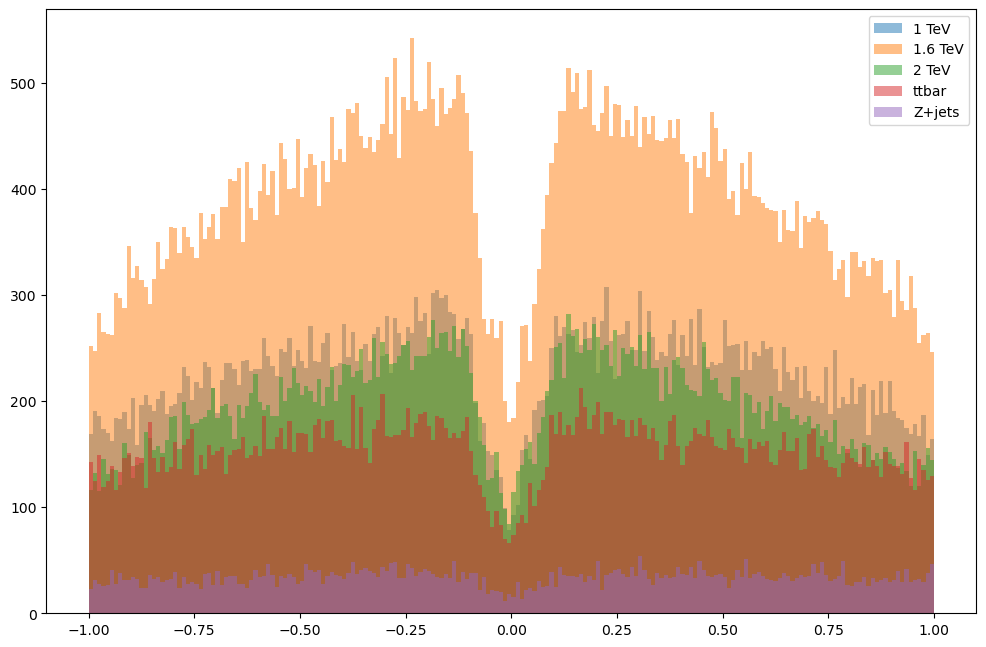

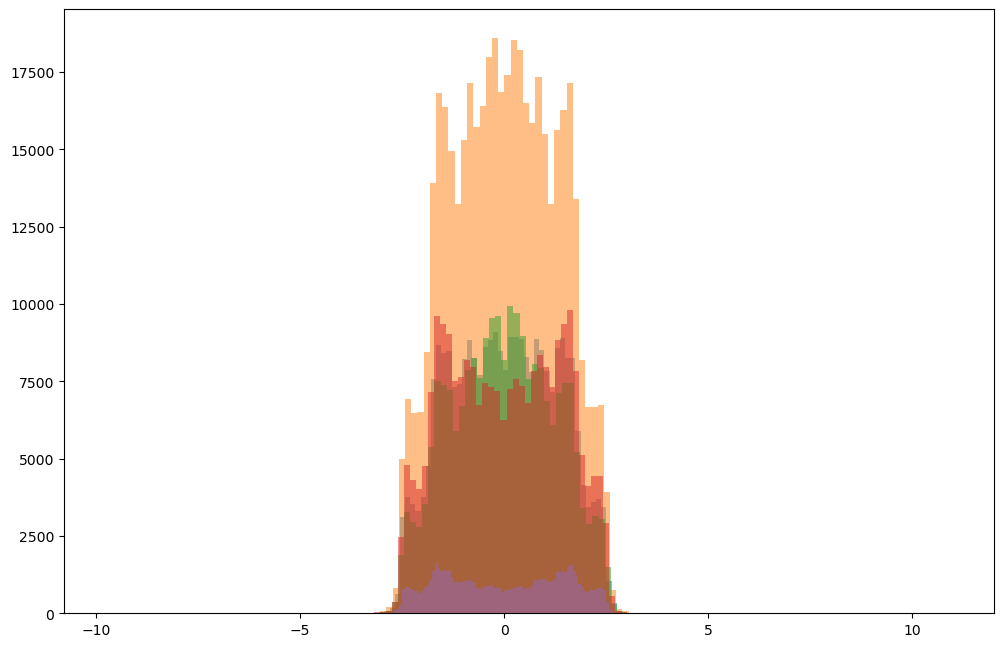

In [17]:
for sample in all_samples:
    branches = sample.branches
    plt.hist(ak.flatten(branches['MuTightEta']), bins=200, alpha=0.5, range=(-1,1), label=sample.short_name)
plt.legend()
plt.show()
for sample in all_samples:
    branches = sample.branches
    plt.hist(ak.flatten(branches['MuEta']), bins=100, alpha=0.5)
plt.show()

## Overall

In [31]:
print('Percentage of events with all relevant reco objects')
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    hadel_branches, hadmu_branches = split_branches_by_channel(branches)

    hadel_taus_mask = boosted_hadel_object_mask(hadel_branches)
    hadel_lrjet_mask = object_mask(hadel_branches, 'LargeRHbbJet')
    hadel_all_masks = [hadel_taus_mask, hadel_lrjet_mask]
    hadel_event_mask = ak.all(hadel_all_masks, axis=0)
    hadel_passed = sum(hadel_event_mask) 
    hadel_total_events = len(hadel_branches)
    hadel_eff = float(hadel_passed) / hadel_total_events
    
    hadmu_taus_mask = boosted_hadmu_object_mask(hadmu_branches)
    hadmu_lrjet_mask = object_mask(hadmu_branches, 'LargeRHbbJet')
    hadmu_all_masks = [hadmu_taus_mask, hadmu_lrjet_mask]
    hadmu_event_mask = ak.all(hadmu_all_masks, axis=0)
    hadmu_passed = sum(hadmu_event_mask) 
    hadmu_total_events = len(hadmu_branches)
    hadmu_eff = float(hadmu_passed) / hadmu_total_events
    
    passed_events = hadel_passed + hadmu_passed
    total_events = hadel_total_events + hadmu_total_events
    
    eff = float(passed_events) / total_events
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with all relevant reco objects

1 TeV
100.0%

1.6 TeV
100.0%

2 TeV
100.0%



In [40]:
print('Percentage of events with reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    hadel_branches, hadmu_branches = split_branches_by_channel(branches)
    
    hadel_event_mask = hadel_whole_tm_event_mask(hadel_branches)
    hadel_passed_events = sum(hadel_event_mask)
    hadel_total_events = len(hadel_branches)
#     print(hadel_passed_events)
#     print(hadel_total_events)
    
    hadmu_event_mask = hadmu_whole_tm_event_mask(hadmu_branches)
    hadmu_passed_events = sum(hadmu_event_mask)
    hadmu_total_events = len(hadmu_branches)
#     print(hadmu_passed_events)
#     print(hadmu_total_events)
    
    passed_events = hadel_passed_events + hadmu_passed_events
    total_events = hadel_total_events + hadmu_total_events
    eff = float(passed_events) / total_events
    
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')        

Percentage of events with reco objects close to truth objects

1 TeV
81.3%

1.6 TeV
87.1%

2 TeV
85.3%



In [47]:
print('Percentage of TM events with selected reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    hadel_branches, hadmu_branches = split_branches_by_channel(branches)    
    
    hadel_whole_event_mask = hadel_whole_tm_event_mask(hadel_branches)
    hadel_selected_whole_event_mask = hadel_whole_selected_tm_event_mask(hadel_branches)
    hadel_num_events = sum(hadel_selected_whole_event_mask)
    hadel_denom_events = sum(hadel_whole_event_mask)
    
    hadmu_whole_event_mask = hadmu_whole_tm_event_mask(hadmu_branches)
    hadmu_selected_whole_event_mask = hadmu_whole_selected_tm_event_mask(hadmu_branches)
    hadmu_num_events = sum(hadmu_selected_whole_event_mask)
    hadmu_denom_events = sum(hadmu_whole_event_mask)
    
    num_events = hadel_num_events + hadmu_num_events
    denom_events = hadel_denom_events + hadmu_denom_events
    eff = float(num_events) / denom_events
    
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')      

Percentage of TM events with selected reco objects close to truth objects

1 TeV
76.4%

1.6 TeV
87.1%

2 TeV
87.1%



## Hbb Tagging

In [6]:
max_dr = 0.2
print('Percentage of events with an Hbb large-R jet within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    eff = eff_truthmatch_branch(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with an Hbb large-R jet within 0.2 of truth Higgs

1 TeV
88.4%

1.6 TeV
96.7%

2 TeV
97.2%



In [7]:
max_dr = 1
print('Percentage of events with "best" Hbb large-R jet within {} of either/both bs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    either_eff, both_eff = frac_best_hbbjet_close_to_truth(branches, max_dr)
    print(sample.short_name)
    print('Either: {:.1%}    Both: {:.1%}'.format(either_eff, both_eff))
    print('')

Percentage of events with "best" Hbb large-R jet within 1 of either/both bs

1 TeV
Either: 91.9%    Both: 73.2%

1.6 TeV
Either: 91.5%    Both: 85.7%

2 TeV
Either: 91.6%    Both: 87.8%



In [8]:
max_dr = 0.2
print('Percentage of events whose leading Hbb large-R jet is within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    eff = frac_leading_reco_close_to_truth(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events whose leading Hbb large-R jet is within 0.2 of truth Higgs

1 TeV
58.8%

1.6 TeV
84.8%

2 TeV
85.9%



In [12]:
max_dr = 0.2
print('Percentage of truth-matched events whose leading Hbb large-R jet is within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_branches
    eff = frac_tm_is_leading_reco(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  

Percentage of truth-matched events whose leading Hbb large-R jet is within 0.2 of truth Higgs

1 TeV
66.6%

1.6 TeV
87.7%

2 TeV
88.4%



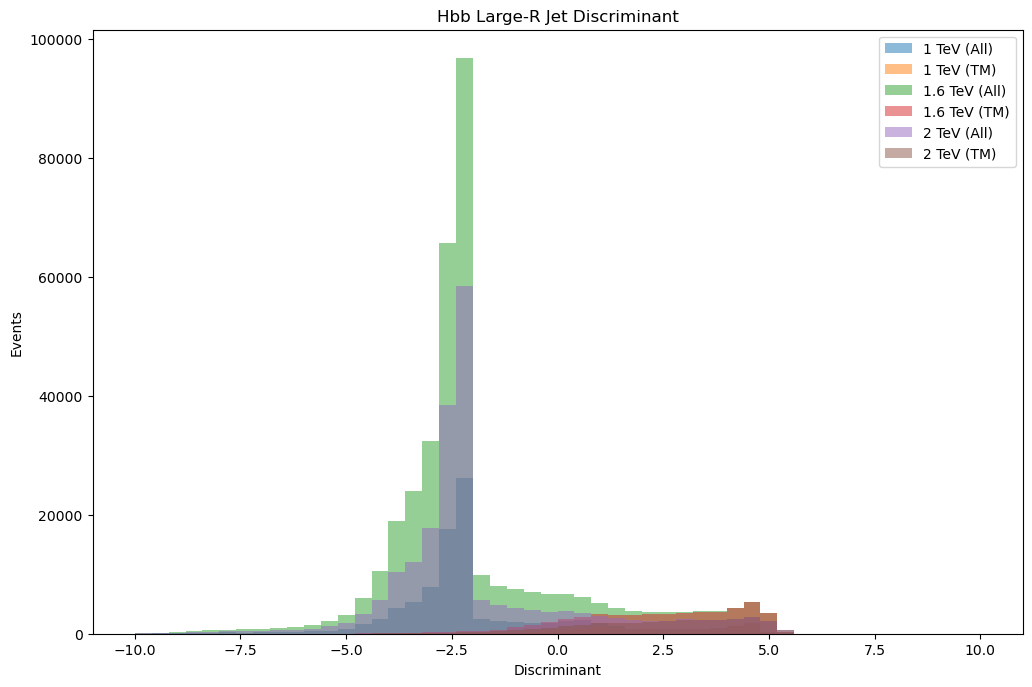

In [35]:
nbins = 50
xrange = [-10, 10]
alpha = 0.5

for sample in signal_samples:
    branches = sample.fid_branches
    tm_jet_mask = get_tm_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', 0.2)
    tm_discs = branches['LargeRHbbJetDiscriminant'][tm_jet_mask]
    plt.hist(ak.flatten(branches['LargeRHbbJetDiscriminant']), nbins, xrange, alpha=alpha, label=f'{sample.short_name} (All)')
    plt.hist(ak.flatten(tm_discs), nbins, xrange, alpha=alpha, label=f'{sample.short_name} (TM)')
plt.title('Hbb Large-R Jet Discriminant')
plt.xlabel('Discriminant')
plt.ylabel('Events')
plt.legend()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/array/base.py:382: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return issubclass(x, cls.numpy.integer) and not issubclass(x, (cls.numpy.bool_, cls.numpy.bool))
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/array/base.py:378: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

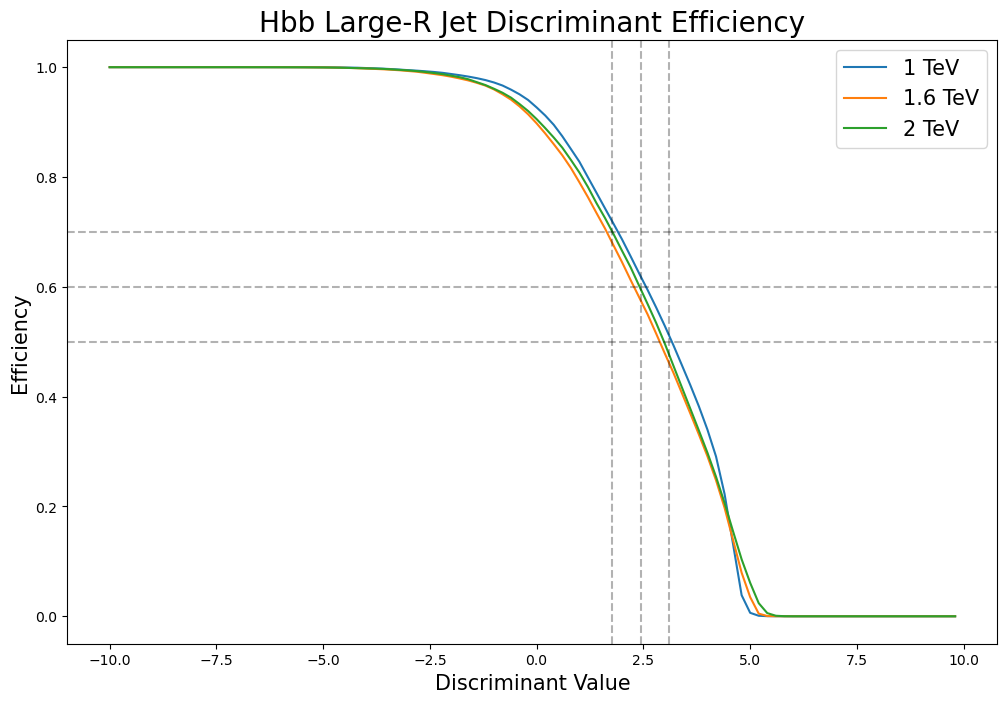

In [12]:
nbins = 50
xrange = [-10, 10]
alpha = 0.5
neffs = 100
xvals = [xrange[0] + i * ( (xrange[1] - xrange[0]) / neffs ) for i in range(neffs)]
for sample in signal_samples:
    branches = sample.branches
    #tm_jet_mask = truthmatch_hbb_lrjet_mask(branches, 0.2)
    tm_jet_mask = hbb_preselection_mask(branches, 0.2)
    tm_discs = ak.flatten(branches['LargeRHbbJetDiscriminant'][tm_jet_mask])
    total_events = len(tm_discs)
    effs = np.zeros(neffs)
    for i, cutoff in enumerate(xvals):
        npassing = sum(tm_discs > cutoff)
        eff = npassing / total_events
        effs[i] = eff
    plt.plot(xvals, effs, label=sample.short_name)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3)
plt.axhline(0.6, color='black', linestyle='--', alpha=0.3)
plt.axhline(0.7, color='black', linestyle='--', alpha=0.3)
plt.axvline(3.09, color='black', linestyle='--', alpha=0.3)
plt.axvline(2.44, color='black', linestyle='--', alpha=0.3)
plt.axvline(1.76, color='black', linestyle='--', alpha=0.3)
plt.title('Hbb Large-R Jet Discriminant Efficiency', size=20)
plt.xlabel('Discriminant Value', fontsize=15)
plt.ylabel('Efficiency', fontsize=15)
plt.legend(fontsize=15)
plt.show()

[True, False, False, False, False, False, False, False, False]
[425, 312, 77.8, 63.9, 60.6, 56.2, 48.7, 46.9, 34.3]
[0.02, 3.21, 2.9, 2.19, 1.94, 1.98, 1.92, 3.34, 2.13]


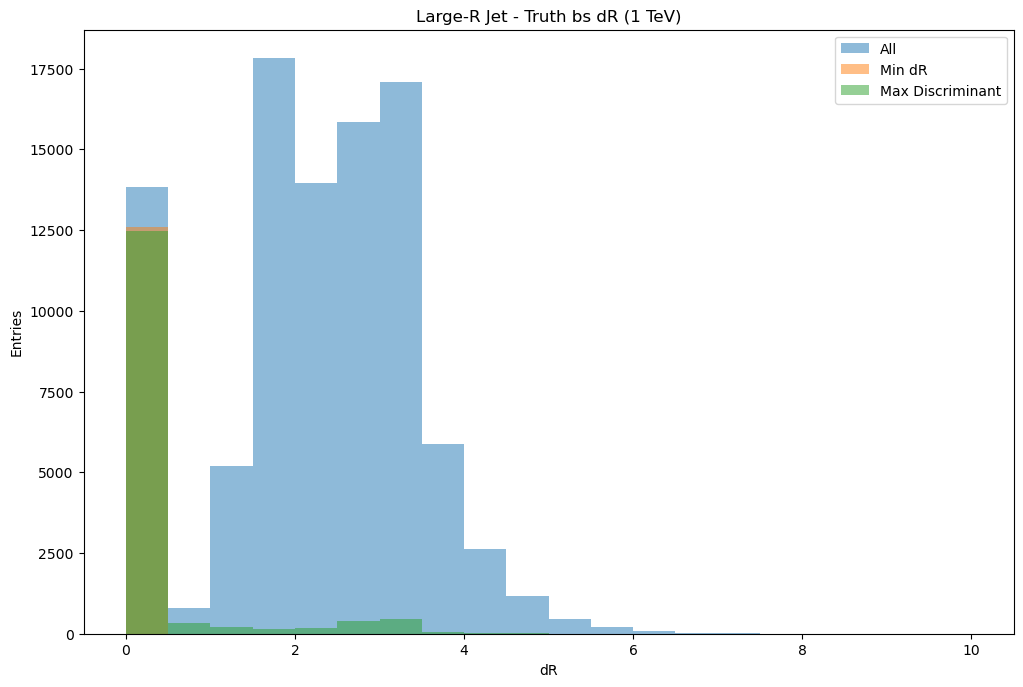

In [9]:
branches = sig10_sample.fid_branches
min_hbb_truth_drs = [min(drs) for drs in branches['LargeRHbbJetTruthdR'] if len(drs) > 0]
dr_of_max_disc = get_branch_of_max_disc_jet(branches, 'LargeRHbbJetTruthdR')

tm_jet_mask = truthmatch_hbb_lrjet_mask(branches, 0.2)
print(tm_jet_mask[1])
print(branches['LargeRHbbJetPt'][1])
print(branches['LargeRHbbJetTruthdR'][1])
tm_drs = ak.flatten(branches['LargeRHbbJetTruthdR'][tm_jet_mask])

nbins = 20
xrange = [0, 10]
plt.hist(ak.flatten(branches['LargeRHbbJetTruthdR']), nbins, xrange, alpha=0.5, label='All')
plt.hist(tm_drs, nbins, xrange, alpha=0.5, label='Min dR')
plt.hist(dr_of_max_disc, nbins, xrange, alpha=0.5, label='Max Discriminant')
plt.title('Large-R Jet - Truth bs dR (1 TeV)')
plt.xlabel('dR')
plt.ylabel('Entries')
plt.legend()
plt.show()

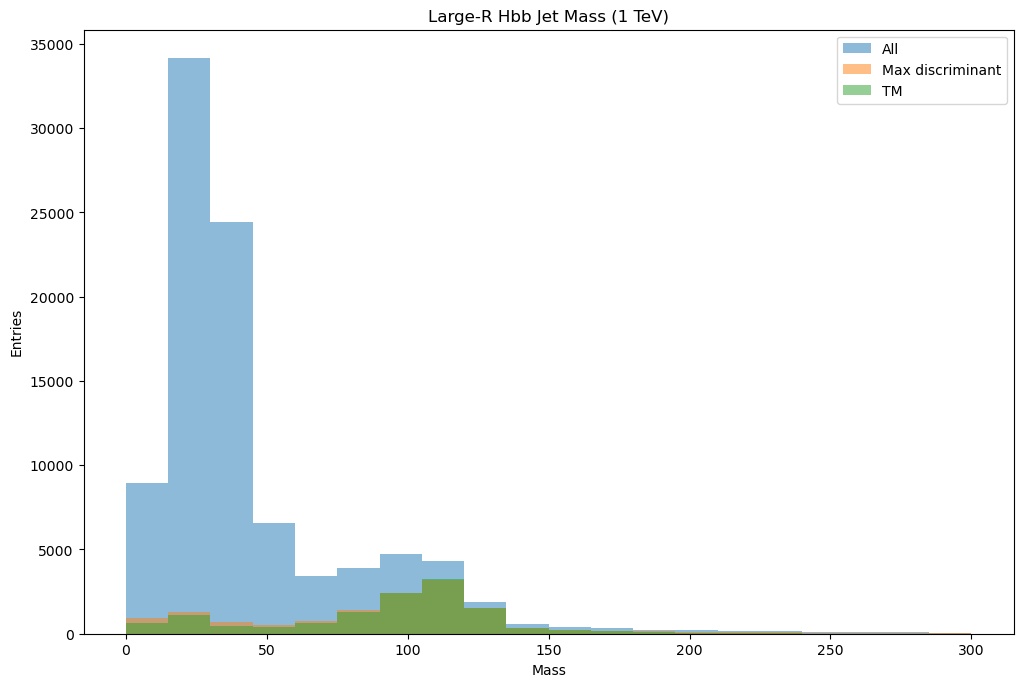

In [9]:
branches = sig10_sample.fid_branches
max_disc_ms = get_branch_of_max_disc_jet(branches, 'LargeRHbbJetM')

#tm_jet_mask = hbb_preselection_mask(branches, 0.2)
tm_jet_mask = truthmatch_hbb_lrjet_mask(branches, 0.2)
tm_masses = ak.flatten(branches['LargeRHbbJetM'][tm_jet_mask])

nbins = 20
xrange = [0, 300]
plt.hist(ak.flatten(branches['LargeRHbbJetM']), nbins, xrange, alpha=0.5, label='All')
plt.hist(max_disc_ms, nbins, xrange, alpha=0.5, label='Max discriminant')
plt.hist(tm_masses, nbins, xrange, alpha=0.5, label='TM')
plt.title('Large-R Hbb Jet Mass (1 TeV)')
plt.xlabel('Mass')
plt.ylabel('Entries')
plt.legend()
plt.show()

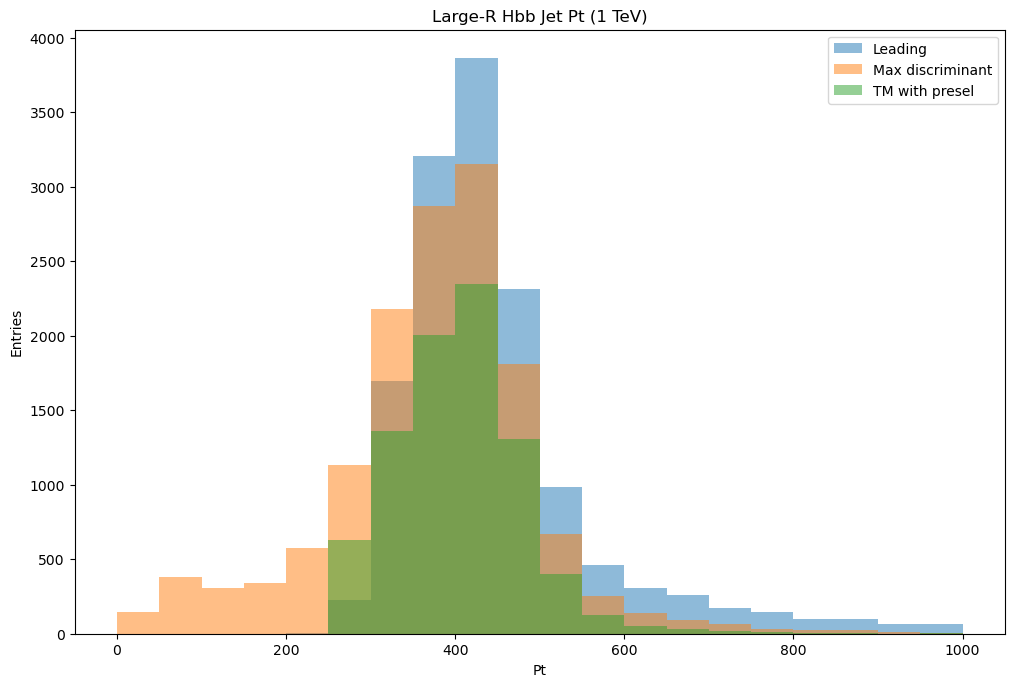

In [35]:
branches = sig10_sample.fid_branches

max_disc_pts = get_branch_of_max_disc_jet(branches, 'LargeRHbbJetPt')

leading_pts = [max(pts) for pts in branches['LargeRHbbJetPt']]

#tm_jet_mask = hbb_preselection_mask(branches, 0.2)
tm_jet_mask = truthmatch_hbb_lrjet_mask(branches, 0.2)
tm_pts = ak.flatten(branches['LargeRHbbJetPt'][tm_jet_mask])

nbins = 20
xrange = [0, 1000]
alpha = 0.5
#plt.hist(ak.flatten(branches['LargeRHbbJetPt']), nbins, xrange, alpha=alpha, label='All')
plt.hist(leading_pts, nbins, xrange, alpha=alpha, label='Leading')
plt.hist(max_disc_pts, nbins, xrange, alpha=alpha, label='Max discriminant')
plt.hist(tm_pts, nbins, xrange, alpha=alpha, label='TM')
plt.title('Large-R Hbb Jet Pt (1 TeV)')
plt.xlabel('Pt')
plt.ylabel('Entries')
plt.legend()
plt.show()

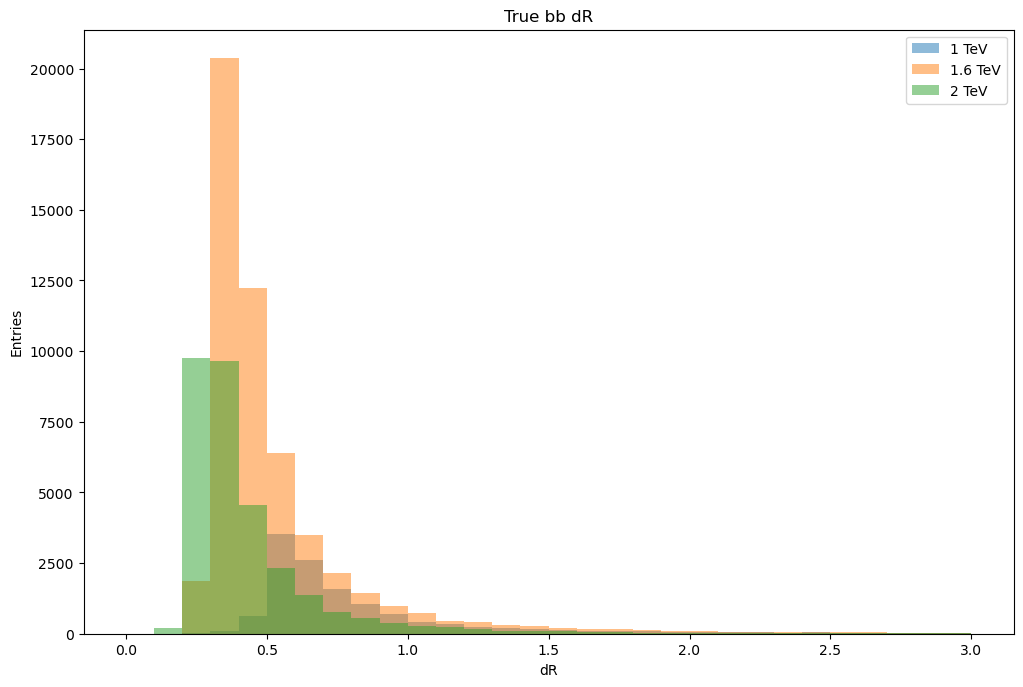

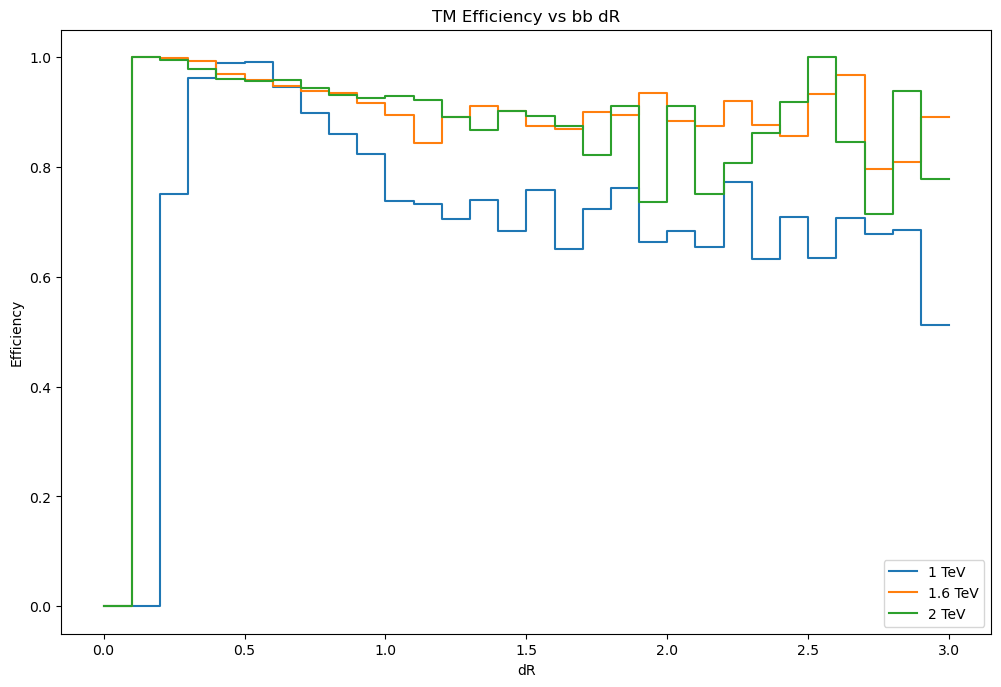

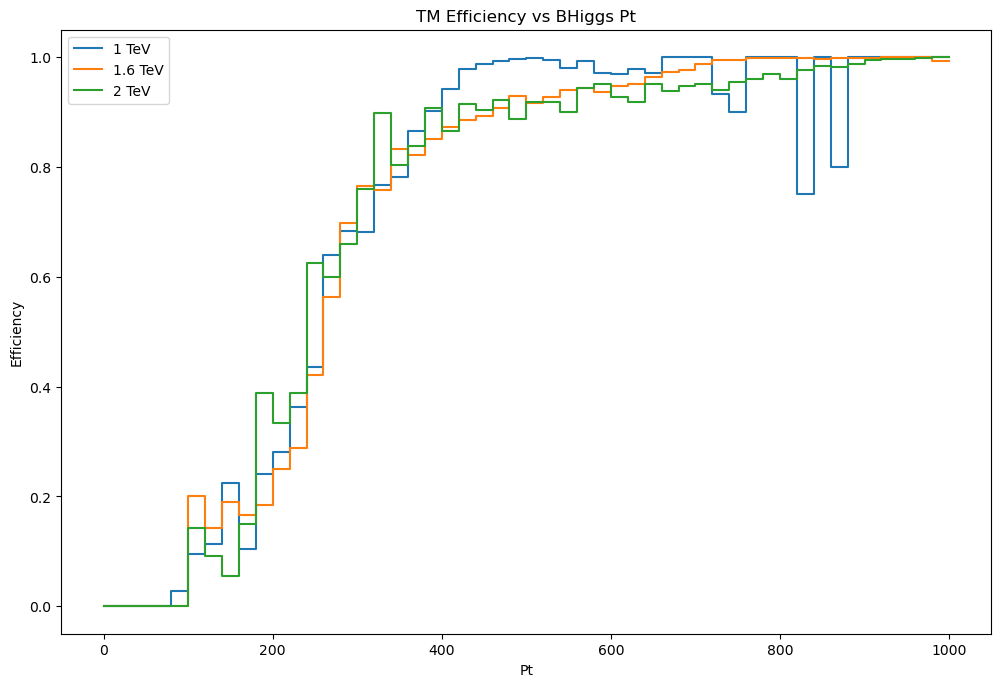

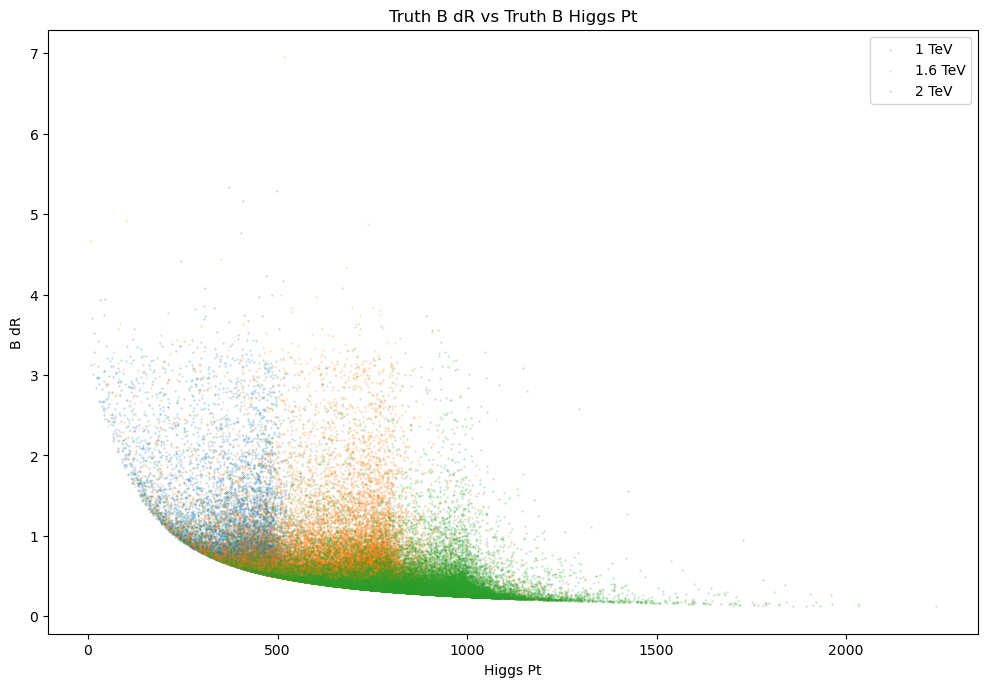

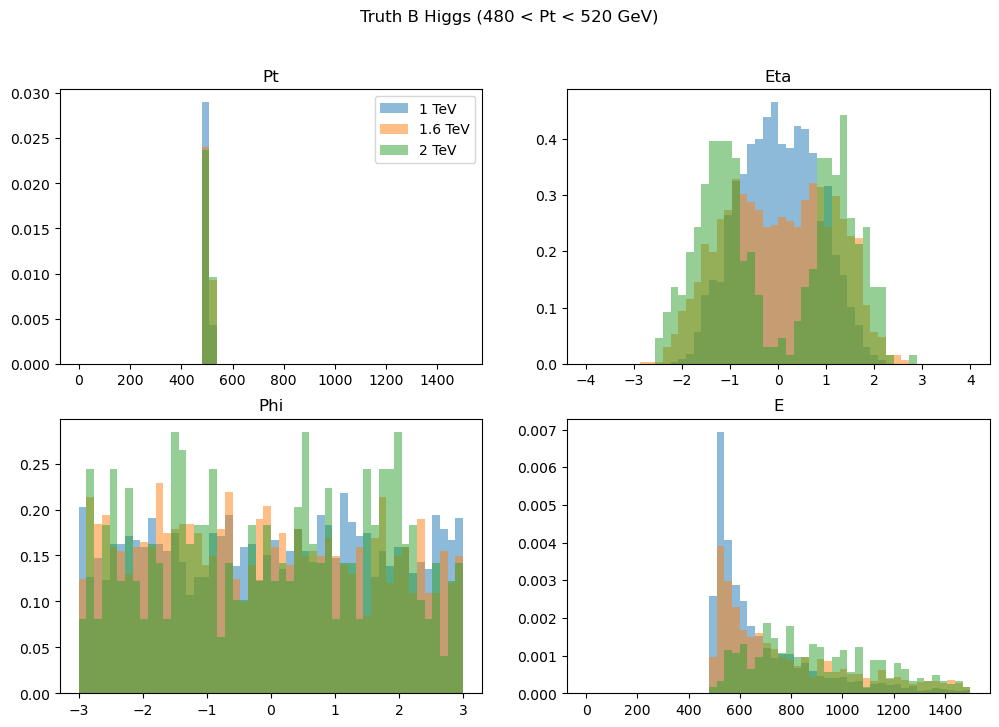

In [8]:
import math
#branches = sig10_sample.fid_branches
tm_dr = 0.2
min_disc = 2
nbins = 30
xrange = [0, 3]
alpha = 0.5
step_width = (xrange[1] - xrange[0]) / nbins


for sample in signal_samples:
    branches = sample.fid_branches
    drs = branches['TruthBdR']
    tm_event_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', tm_dr)
    drs_hbb_truthmatch = drs[tm_event_mask]

    #tm_disc_mask = truthmatch_hbb_lrjet_event_mask(branches, tm_dr, min_disc)
    #drs_tm_disc = drs[tm_disc_mask]

    #plt.hist(drs, nbins, xrange, alpha=alpha, label='All')
    #plt.hist(drs_hbb_truthmatch, nbins, xrange, alpha=alpha, label='TM')
    plt.hist(drs_hbb_truthmatch, nbins, xrange, alpha=alpha, label=sample.short_name)
plt.title('True bb dR')
plt.xlabel('dR')
plt.ylabel('Entries')
plt.legend()
plt.show()

for sample in signal_samples:
    branches = sample.fid_branches
    drs = branches['TruthBdR']
    tm_events_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', tm_dr)
    tm_drs = drs[tm_events_mask]

    tm_eff_x, tm_eff_y = eff_hist_lists(np.array(tm_drs), np.array(drs), xrange[0], xrange[1], nbins)
    tm_eff_y = [val if not math.isnan(val) else 0 for val in tm_eff_y]
    
    plt.plot(tm_eff_x, tm_eff_y, drawstyle='steps', label=sample.short_name)
plt.title('TM Efficiency vs bb dR')
plt.xlabel('dR')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

#Pt
for sample in signal_samples:
    branches = sample.fid_branches
    pts = branches['TruthBHiggsPt']
    tm_events_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', tm_dr)
    tm_pts = pts[tm_events_mask]

    tm_eff_x, tm_eff_y = eff_hist_lists(np.array(tm_pts), np.array(pts), 0, 1000, 50)
    tm_eff_y = [val if not math.isnan(val) else 0 for val in tm_eff_y]
    
    plt.plot(tm_eff_x, tm_eff_y, drawstyle='steps', label=sample.short_name)
plt.title('TM Efficiency vs BHiggs Pt')
plt.xlabel('Pt')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

for sample in signal_samples:
    branches = sample.fid_branches
    pts = branches['TruthBHiggsPt']
    drs = branches['TruthBdR']
    plt.scatter(pts, drs, alpha=0.5, s=0.1, label=sample.short_name)
plt.title('Truth B dR vs Truth B Higgs Pt')
plt.xlabel('Higgs Pt')
plt.ylabel('B dR')
plt.legend()
plt.show()

def p4_breakdown(sample, branches, branch_name):
    pt_branch_name = f'{branch_name}Pt'
    pt_branch = branches[pt_branch_name]
    pt_bins = 50
    pt_min, pt_max, = 0, 1500
    pt_weights = norm_hist_weights(pt_branch, pt_bins, pt_min, pt_max)
    axs[0, 0].hist(pt_branch, bins=pt_bins, range=(pt_min, pt_max), weights=pt_weights, alpha=0.5, label=sample.short_name)
    axs[0, 0].set_title('Pt')
    axs[0, 0].legend()
    
    eta_branch_name = f'{branch_name}Eta'
    eta_branch = branches[eta_branch_name]
    eta_bins = 50
    eta_min, eta_max, = -4, 4
    eta_weights = norm_hist_weights(eta_branch, eta_bins, eta_min, eta_max)
    axs[0, 1].hist(eta_branch, bins=eta_bins, range=(eta_min, eta_max), weights=eta_weights, alpha=0.5, label=sample.short_name)
    axs[0, 1].set_title('Eta')
    
    phi_branch_name = f'{branch_name}Phi'
    phi_branch = branches[phi_branch_name]
    phi_bins = 50
    phi_min, phi_max, = -3, 3
    phi_weights = norm_hist_weights(phi_branch, phi_bins, phi_min, phi_max)
    axs[1, 0].hist(phi_branch, bins=phi_bins, range=(phi_min, phi_max), weights=phi_weights, alpha=0.5, label=sample.short_name)
    axs[1, 0].set_title('Phi')
    
    e_branch_name = f'{branch_name}E'
    e_branch = branches[e_branch_name]
    e_bins = 50
    e_min, e_max, = 0, 1500
    e_weights = norm_hist_weights(e_branch, e_bins, e_min, e_max)
    axs[1, 1].hist(e_branch, bins=e_bins, range=(e_min, e_max), weights=e_weights, alpha=0.5, label=sample.short_name)
    axs[1, 1].set_title('E')
    
    
figs, axs = plt.subplots(2, 2)
for sample in signal_samples:
    branches = sample.fid_branches
    tm_events_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', tm_dr)
    pt_mask = abs(branches['TruthBHiggsPt'] - 500) < 20
    all_mask = ak.all([tm_events_mask, pt_mask], axis=0)
    masked_branches = branches[all_mask]
    p4_breakdown(sample, masked_branches, 'TruthBHiggs')
plt.suptitle('Truth B Higgs (480 < Pt < 520 GeV)')
plt.show()

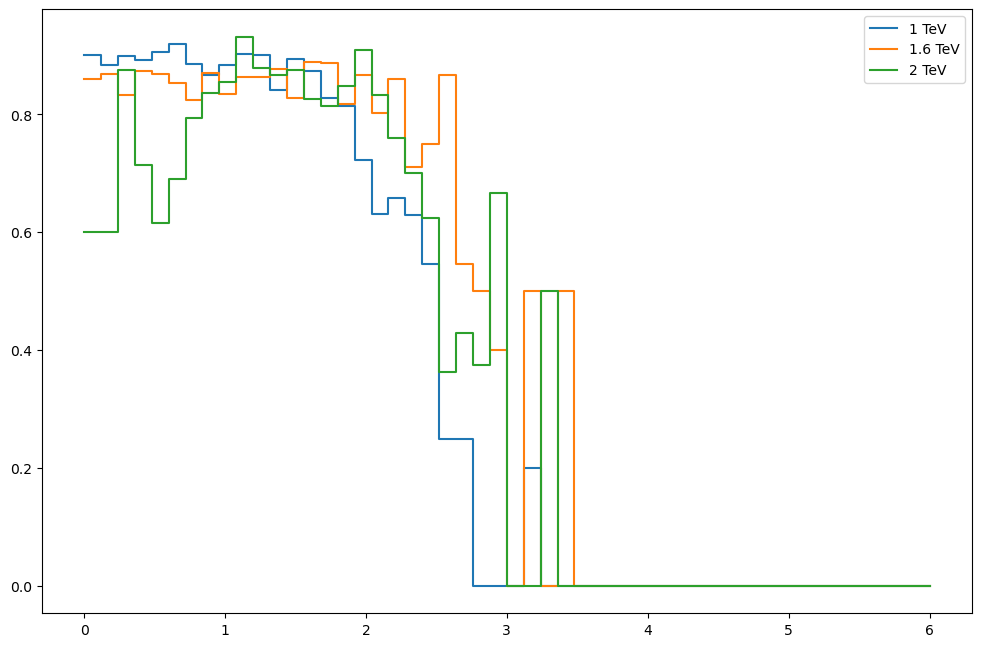

In [24]:
for sample in signal_samples:
    branches = sample.fid_branches
    tm_event_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', tm_dr)
    pt_mask = abs(branches['TruthBHiggsPt']) - 500 < 20
    pt_branches = branches[pt_mask]
    mask = ak.all([tm_event_mask, pt_mask], axis=0)
    masked_branches = branches[mask]
    etas = pt_branches['TruthBHiggsEta']
    tm_etas = masked_branches['TruthBHiggsEta']
    
    tm_eff_x, tm_eff_y = eff_hist_lists(np.array(tm_etas), np.array(etas), 0, 6, 50)
    tm_eff_y = [val if not math.isnan(val) else 0 for val in tm_eff_y]
    
    plt.plot(tm_eff_x, tm_eff_y, drawstyle='steps', label=sample.short_name)
plt.legend()
plt.show()

In [7]:
for sample in signal_samples:
    branches = sample.fid_branches
    drs = truth_btag_drs(branches)
    tm_event_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', tm_dr)
    drs_hbb_truthmatch = drs[tm_event_mask]
    
    tm_disc_mask = truthmatch_hbb_lrjet_event_mask(branches, tm_dr, min_disc)
    drs_tm_disc = drs[tm_disc_mask]
    
    
    # Efficiency of truth-matching
    tm_eff_x, tm_eff_y = eff_hist_lists(drs_hbb_truthmatch, drs, xrange[0], xrange[1], nbins)
    tm_eff_y = [val if not math.isnan(val) else 0 for val in tm_eff_y]
    # Efficiency of truth-matching with discriminant cut 
    tm_disc_eff_x, tm_disc_eff_y = eff_hist_lists(drs_tm_disc, drs, xrange[0], xrange[1], nbins)
    tm_disc_eff_y = [val if not math.isnan(val) else 0 for val in tm_disc_eff_y]
    # Efficiency of discrimant cut on truth-matched
    disc_eff_x, disc_eff_y = eff_hist_lists(drs_tm_disc, drs_hbb_truthmatch, xrange[0], xrange[1], nbins)
    disc_eff_y = [val if not math.isnan(val) else 0 for val in disc_eff_y]

    #plt.plot(tm_eff_x, tm_eff_y, drawstyle='steps', label='TM', alpha=0.2)
    #plt.plot(tm_disc_eff_x, tm_disc_eff_y, drawstyle='steps', label='TM + discriminant cut', alpha=0.2)
    plt.plot(disc_eff_x, disc_eff_y, drawstyle='steps', label=sample.short_name)
plt.title('Discriminant Efficiency vs bb dR')
plt.xlabel('dR')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

NameError: name 'get_tm_event_mask' is not defined

# HadEl

### Summary

In [70]:
print('Percentage of events with all relevant reco objects (Large-R jets, loose electrons, taus*)')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    hadel_mask = boosted_hadel_object_mask(branches)
    lrjet_mask = object_mask(branches, 'LargeRHbbJet')
    all_masks = [hadel_mask, lrjet_mask]
    event_mask = ak.all(all_masks, axis=0)
    eff = sum(event_mask) / len(branches)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with all relevant reco objects (Large-R jets, loose electrons, taus*)

1 TeV
98.0%

1.6 TeV
97.2%

2 TeV
96.1%



In [21]:
print('Percentage of events with reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    event_mask = hadel_whole_tm_event_mask(branches)
    eff = sum(event_mask) / len(branches)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with reco objects close to truth objects

1 TeV
85.1%

1.6 TeV
90.7%

2 TeV
89.2%



In [23]:
print('Percentage of events with selected reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    event_mask = hadel_whole_selected_tm_event_mask(branches)
    eff = sum(event_mask) / len(branches)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')    

Percentage of events with selected reco objects close to truth objects

1 TeV
65.3%

1.6 TeV
79.2%

2 TeV
78.6%



In [24]:
print('Percentage of TM events with selected reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    whole_event_mask = hadel_whole_tm_event_mask(branches)
    selected_whole_event_mask = hadel_whole_selected_tm_event_mask(branches)
    eff = sum(selected_whole_event_mask) / sum(whole_event_mask)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  

Percentage of TM events with selected reco objects close to truth objects

1 TeV
76.8%

1.6 TeV
87.3%

2 TeV
88.1%



## Electrons

In [7]:
print('Percentage of events with at least one electron')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(object_efficiency(branches, 'Ele')))
    print('')

Percentage of events with at least one electron

1 TeV
100.0%

1.6 TeV
100.0%

2 TeV
100.0%



In [11]:
print('Percentage of events with electron within dR < 0.1 of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(eff_truthmatch_branch(branches, 'Ele', 'TruthFinalLepton', 0.1)))
    print('')
    

Percentage of events with electron within dR < 0.1 of truth

1 TeV
99.6%

1.6 TeV
99.4%

2 TeV
99.0%



## Loose Electrons

In [76]:
print('Percentage of events with at least one loose electron')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(object_efficiency(branches, 'EleLoose')))
    print('')

Percentage of events with at least one loose electron

1 TeV
98.0%

1.6 TeV
97.2%

2 TeV
96.1%



In [77]:
print('Percentage of events with loose electron within dR < 0.1 of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(eff_truthmatch_branch(branches, 'EleLoose', 'TruthFinalLepton', 0.1)))
    print('')

Percentage of events with loose electron within dR < 0.1 of truth

1 TeV
96.5%

1.6 TeV
95.3%

2 TeV
93.8%



In [78]:
max_dr = 0.1
print('Percentage of events whose leading loose electron is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_leading_reco_close_to_truth(branches, 'EleLoose', 'TruthFinalLepton', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events whose leading loose electron is within 0.1 of truth electron

1 TeV
91.4%

1.6 TeV
89.4%

2 TeV
87.1%



In [27]:
max_dr = 0.1
print('Percentage of truth-matched events whose leading loose electron is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_tm_is_leading_reco(branches, 'EleLoose', 'TruthFinalLepton', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of truth-matched events whose leading loose electron is within 0.1 of truth electron

1 TeV
94.7%

1.6 TeV
93.8%

2 TeV
92.8%



### Chosen Electron

In [21]:
max_dr = 0.1
print('Percentage of truth-matched events whose chosen electron is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_tm_is_chosen_electron(branches, max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of truth-matched events whose chosen electron is within 0.1 of truth electron

1 TeV
95.0%

1.6 TeV
95.9%

2 TeV
96.1%



## Taus

In [80]:
print('Percentage of events with at least one tau')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(object_efficiency(branches, 'Tau')))
    print('')

Percentage of events with at least one tau

1 TeV
100.0%

1.6 TeV
100.0%

2 TeV
100.0%



In [81]:
max_dr = 0.1
print(f'Percentage of events with tau within dR < {max_dr} of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(eff_truthmatch_branch(branches, 'Tau', 'TruthHadTauVis', max_dr)))
    print('')

Percentage of events with tau within dR < 0.1 of truth

1 TeV
95.7%

1.6 TeV
76.7%

2 TeV
66.5%



In [82]:
max_dr = 0.1
print(f'Percentage of events whose leading tau is within dR < {max_dr} of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    print(sample.short_name)
    print('{:.1%}'.format(frac_leading_reco_close_to_truth(branches, 'Tau', 'TruthHadTauVis', max_dr)))
    print('')    

Percentage of events whose leading tau is within dR < 0.1 of truth

1 TeV
28.7%

1.6 TeV
12.8%

2 TeV
10.1%



In [83]:
max_dr = 0.1
print('Percentage of truth-matched events whose leading tau is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_tm_is_leading_reco(branches, 'Tau', 'TruthHadTauVis', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')    

Percentage of truth-matched events whose leading tau is within 0.1 of truth electron

1 TeV
29.9%

1.6 TeV
16.7%

2 TeV
15.2%



## Tau-Ele System

In [84]:
max_dr = 0.1
print(f'Percentage of events with a loose electron within {max_dr} of truth electron and tau/subjet within {max_dr} of truth tau')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = boosted_hadel_tm_eff(branches, max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with a loose electron within 0.1 of truth electron and tau/subjet within 0.1 of truth tau

1 TeV
96.1%

1.6 TeV
93.7%

2 TeV
91.6%



In [85]:
max_dr = 0.1
print('Percentage of events with both chosen objects lying within dR < 0.1 of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    hadel_mask = chosen_hadel_close_to_truth_mask(branches, max_dr)
    both_eff = sum(hadel_mask) / len(branches)
    electron_eff, tau_eff = chosen_boosted_eletau_efficiencies(branches)
    print(sample.short_name)
    print('Electron: {:.1%}'.format(electron_eff))
    print('Tau: {:.1%}'.format(tau_eff))
    print('Both: {:.1%}'.format(both_eff))
    print('')

Percentage of events with both chosen objects lying within dR < 0.1 of truth

1 TeV
Electron: 91.7%
Tau: 87.2%
Both: 87.0%

1.6 TeV
Electron: 91.4%
Tau: 85.6%
Both: 85.5%

2 TeV
Electron: 90.2%
Tau: 84.1%
Both: 84.0%



In [86]:
max_dr = 0.1
print(f'Percentage of TM events with both chosen objects within {max_dr} of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_tm_is_chosen_hadel(branches, max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of TM events with both chosen objects within 0.1 of truth

1 TeV
90.6%

1.6 TeV
91.2%

2 TeV
91.6%



### Hbb Large-R Jets

In [88]:
max_dr = 0.2
print('Percentage of events with an Hbb large-R jet within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = eff_truthmatch_branch(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with an Hbb large-R jet within 0.2 of truth Higgs

1 TeV
88.4%

1.6 TeV
96.6%

2 TeV
97.2%



In [32]:
max_dr = 0.2
print('Percentage of events whose leading Hbb large-R jet is within {} of truth b Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_leading_reco_close_to_truth(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events whose leading Hbb large-R jet is within 0.2 of truth b Higgs

1 TeV
50.3%

1.6 TeV
80.1%

2 TeV
82.3%



In [157]:
max_dr = 0.2
print('Percentage of truth-matched events whose leading Hbb large-R jet is within {} of truth b Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    eff = frac_tm_is_leading_reco(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  

Percentage of truth-matched events whose leading Hbb large-R jet is within 0.2 of truth b Higgs

1 TeV
56.8%

1.6 TeV
82.9%

2 TeV
84.6%



In [186]:
max_dr = 0.2
print('Percentage of (b Higgs) truth-matched events whose leading Hbb large-R jet is within {} of truth tau Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    
    event_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    reco_pt_name = '{}Pt'.format('LargeRHbbJet')
    masked_pts = branches[reco_pt_name][event_mask]
    leading_reco_pts = np.array([max(pts) for pts in masked_pts if len(pts) > 0])
    object_mask = get_tm_mask(branches, 'LargeRHbbJet', 'TruthTauHiggs', max_dr)
    tm_reco_pts = branches[reco_pt_name][object_mask][event_mask]
    # There may be multiple TM reco objects, so choose the leading
    tm_reco_pts = np.array([max(pts) if len(pts) > 0 else 0 for pts in tm_reco_pts])
    mask = np.equal(tm_reco_pts, leading_reco_pts)
    leading_tm_count = sum(mask)
    tm_count = sum(event_mask)
    frac = leading_tm_count / tm_count
    eff = frac
    
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  
    

Percentage of (b Higgs) truth-matched events whose leading Hbb large-R jet is within 0.2 of truth tau Higgs

1 TeV
32.7%

1.6 TeV
14.4%

2 TeV
12.0%



### Off-lepton Large-R Jet    

In [37]:
max_dr = 0.2
print('Percentage of truth-matched events whose off-lepton Hbb large-R jet is within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadel_branches
    
    event_tm_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', 0.2)
    event_tm_branches = branches[event_tm_mask]
    dr_mask = event_tm_branches['HadElLargeRHbbJetTruthdR'] < 0.2
    dr_branches = event_tm_branches[dr_mask]
    eff = len(dr_branches) / len(event_tm_branches)
    
    
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  

Percentage of truth-matched events whose off-lepton Hbb large-R jet is within 0.2 of truth Higgs

1 TeV
83.4%

1.6 TeV
93.7%

2 TeV
93.1%



### Btag Jets

In [3]:
print('Percentage of events with at least one btag jet')
print('')
print('1 TeV')
print('{:.1%}'.format(btag_efficiency(sig10_sample.fid_hadel_branches)))
print('')
print('1.6 TeV')
print('{:.1%}'.format(btag_efficiency(sig16_sample.fid_hadel_branches)))
print('')
print('2 TeV')
print('{:.1%}'.format(btag_efficiency(sig20_sample.fid_hadel_branches)))

Percentage of events with at least one btag jet

1 TeV
89.7%

1.6 TeV
83.1%

2 TeV
78.9%


In [72]:
print('Percentage of events with a btag jet within dR < 0.1 of truth bs')
print('')
print('1 TeV')
sig10_btag_effs = get_frac_bs_close_to_truth(sig10_sample.fid_hadel_branches)
print('B: {:.1%}  Anti-B: {:.1%}  Either: {:.1%}  Both: {:.1%}'.format(sig10_btag_effs[0], sig10_btag_effs[1], sig10_btag_effs[2], sig10_btag_effs[3]))
print('1.6 TeV')
sig16_btag_effs = get_frac_bs_close_to_truth(sig16_sample.fid_hadel_branches)
print('B: {:.1%}  Anti-B: {:.1%}  Either: {:.1%}  Both: {:.1%}'.format(sig16_btag_effs[0], sig16_btag_effs[1], sig16_btag_effs[2], sig16_btag_effs[3]))
print('2 TeV')
sig20_btag_effs = get_frac_bs_close_to_truth(sig20_sample.fid_hadel_branches)
print('B: {:.1%}  Anti-B: {:.1%}  Either: {:.1%}  Both: {:.1%}'.format(sig20_btag_effs[0], sig20_btag_effs[1], sig20_btag_effs[2], sig20_btag_effs[3]))

Percentage of events with a btag jet within dR < 0.1 of truth bs

1 TeV
B: 57.4%  Anti-B: 50.0%  Either: 80.9%  Both: 26.5%
1.6 TeV
B: 29.5%  Anti-B: 32.9%  Either: 49.8%  Both: 12.6%
2 TeV
B: 30.2%  Anti-B: 30.9%  Either: 53.5%  Both: 7.6%


In [73]:
dr = 0.4
print('Percentage of events with leading btag jet within dR < {} of either truth b'.format(dr))
print('1 TeV')
print('{:.1%}'.format(get_frac_leading_btag_close_to_truth(sig10_sample.fid_hadel_branches, dr)))
print('')
print('1.6 TeV')
print('{:.1%}'.format(get_frac_leading_btag_close_to_truth(sig16_sample.fid_hadel_branches, dr)))
print('')
print('2 TeV')
print('{:.1%}'.format(get_frac_leading_btag_close_to_truth(sig20_sample.fid_hadel_branches, dr)))

Percentage of events with leading btag jet within dR < 0.4 of either truth b
1 TeV
83.8%

1.6 TeV
80.7%

2 TeV
76.4%


## Jets

In [5]:
dr = 0.4
print('Percentage of events with leading jet within dR < {} of either truth b'.format(dr))
print('1 TeV')
print('{:.1%}'.format(get_frac_leading_jet_close_to_truth(sig10_sample.fid_hadel_branches, dr)))
print('')
print('1.6 TeV')
print('{:.1%}'.format(get_frac_leading_jet_close_to_truth(sig16_sample.fid_hadel_branches, dr)))
print('')
print('2 TeV')
print('{:.1%}'.format(get_frac_leading_jet_close_to_truth(sig20_sample.fid_hadel_branches, dr)))

Percentage of events with leading jet within dR < 0.4 of either truth b
1 TeV
36.8%

1.6 TeV
80.7%

2 TeV
78.9%


In [6]:
dr = 1
print('Percentage of events with leading large-R jet within dR < {} of either truth b'.format(dr))
print('1 TeV')
print('{:.1%}'.format(get_frac_leading_largerjet_close_to_truth(sig10_sample.fid_hadel_branches, dr)))
print('')
print('1.6 TeV')
print('{:.1%}'.format(get_frac_leading_largerjet_close_to_truth(sig16_sample.fid_hadel_branches, dr)))
print('')
print('2 TeV')
print('{:.1%}'.format(get_frac_leading_largerjet_close_to_truth(sig20_sample.fid_hadel_branches, dr)))

Percentage of events with leading large-R jet within dR < 1 of either truth b
1 TeV
52.9%

1.6 TeV
87.4%

2 TeV
88.0%


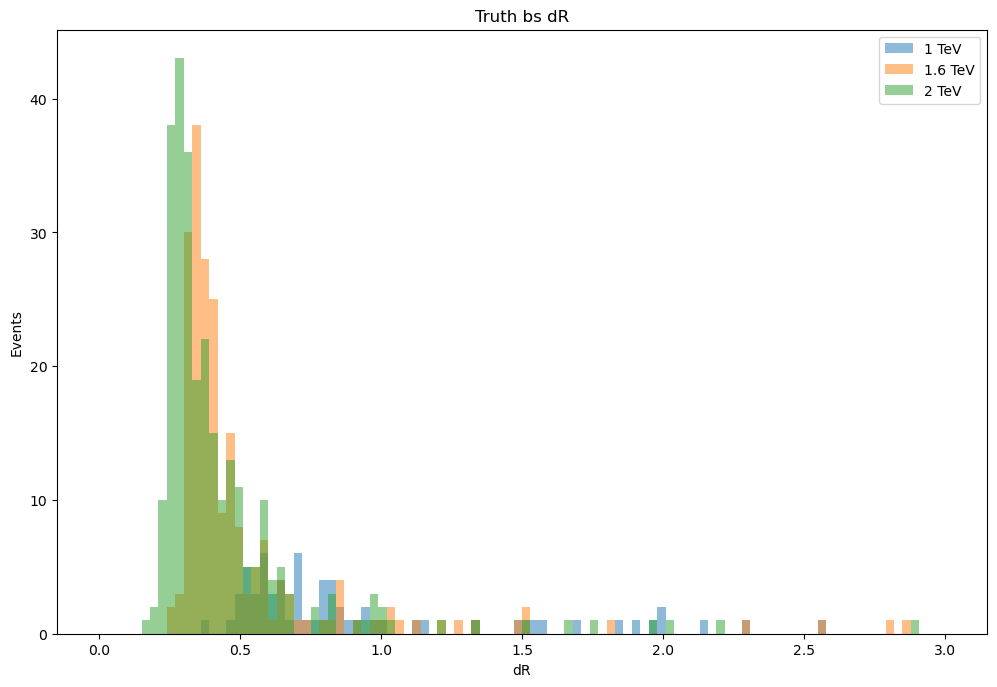

In [7]:
sig10_drs = truth_btag_drs(sig10_sample.fid_hadel_branches)
sig16_drs = truth_btag_drs(sig16_sample.fid_hadel_branches)
sig20_drs = truth_btag_drs(sig20_sample.fid_hadel_branches)

plt.hist(sig10_drs, 100, [0, 3], alpha=0.5, label='1 TeV')
plt.hist(sig16_drs, 100, [0, 3], alpha=0.5, label='1.6 TeV')
plt.hist(sig20_drs, 100, [0, 3], alpha=0.5, label='2 TeV')
plt.title('Truth bs dR')
plt.xlabel('dR')
plt.ylabel('Events')
plt.legend()
plt.show()

## Truth-Matched Reco Tau dR

1.6 TeV: % of true taus with reco within dR <0.1
0.7611599869664386
2 TeV: % of true taus with reco within dR <0.1
0.665258627560373


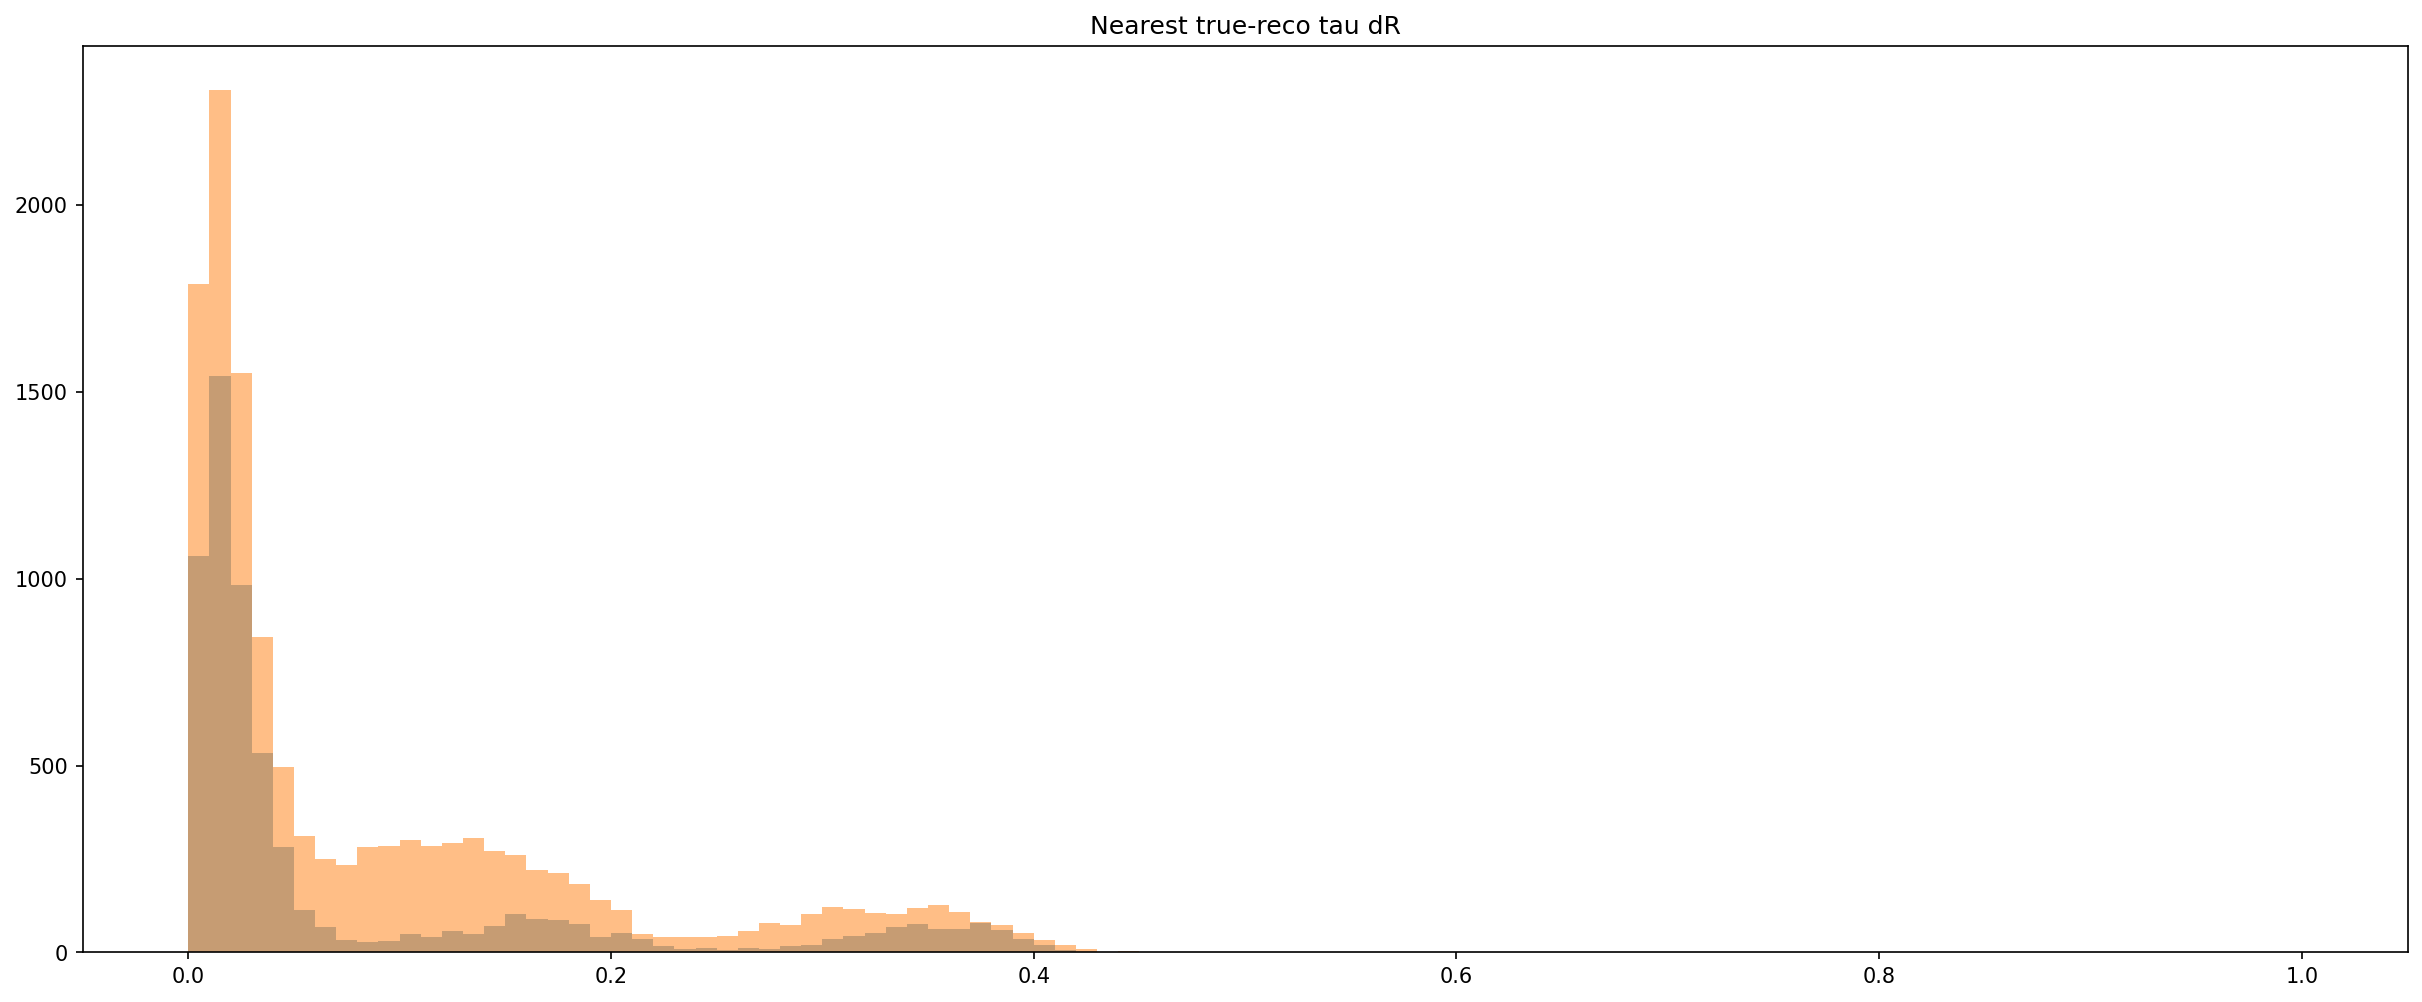

In [76]:
sig16_tau_truereco_drs = sig16_truth_tau_p4s.delta_r(sig16_reco_tau_p4s)
sig16_min_tau_truereco_drs = [min(drs) for drs in sig16_tau_truereco_drs]
sig20_tau_truereco_drs = sig20_truth_tau_p4s.delta_r(sig20_reco_tau_p4s)
sig20_min_tau_truereco_drs = [min(drs) for drs in sig20_tau_truereco_drs]

print('1.6 TeV: % of true taus with reco within dR <0.1')
print(sum(np.array(sig16_min_tau_truereco_drs) < 0.1) / len(sig16_min_tau_truereco_drs))
print('2 TeV: % of true taus with reco within dR <0.1')
print(sum(np.array(sig20_min_tau_truereco_drs) < 0.1) / len(sig20_min_tau_truereco_drs))
plt.hist(sig16_min_tau_truereco_drs, 100, (0, 1), alpha=0.5)
plt.hist(sig20_min_tau_truereco_drs, 100, (0, 1), alpha=0.5)
plt.title('Nearest true-reco tau dR')
plt.show()

## Truth-Matched Reco Tau Pt

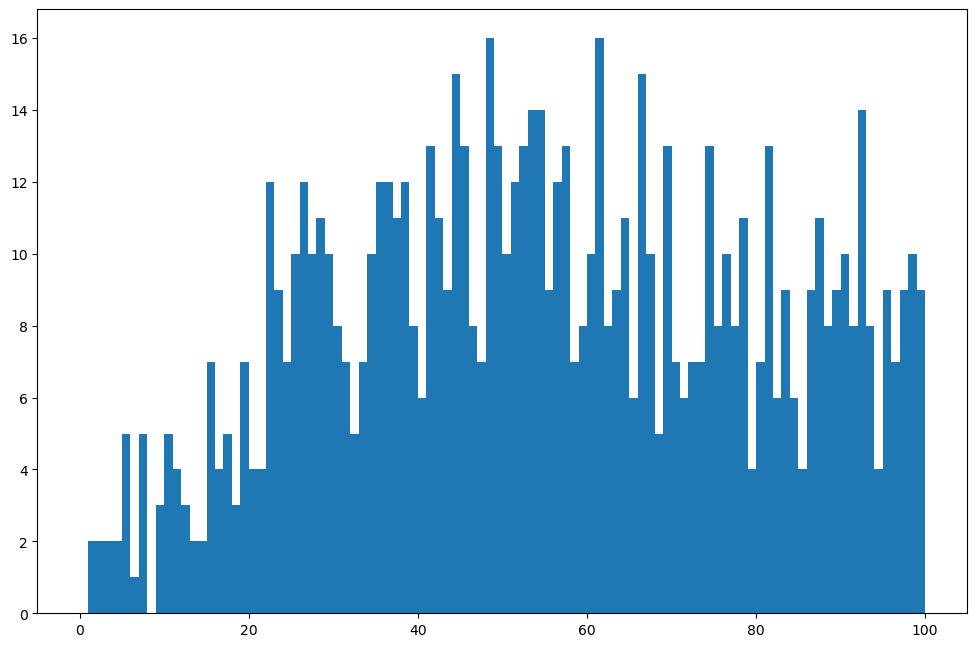

0.9903831705484598


In [18]:
plt.hist(sig16_nearest_reco_tau_p4s.pt, 100, (0, 100))
plt.show()
pts = sig16_nearest_reco_tau_p4s.pt > 20
print(sum(pts) / len(pts))

In [46]:
# For each event get the index of chosen tau-ele combo
def get_chosen_dr_index(branches, min_dr):
    min_dr_indices = []
    for drs in branches['TauEleLoosedR']:
        if len(drs) == 0:
            index = None
        elif len(list(dr for dr in drs if dr > min_dr)) == 0:
            index = list(drs).index(min(drs))
        else:
            index = list(drs).index(min(dr for dr in drs if dr > min_dr))
        min_dr_indices.append(index)
    return min_dr_indices

# Given branches and an index for each event, get the dr of chosen combo
def get_chosen_dr(indices, branches):
    min_drs = [drs[indices] for drs, indices in zip(branches['TauEleLoosedR'], indices) if indices is not None]
    return min_drs       

def plot_tau_reco_truth_comp_dr(branches, min_dr, plotter):
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['figure.dpi'] = 150
    min_dr_indices = get_chosen_dr_index(branches, min_dr)
    reco_drs = get_chosen_dr(min_dr_indices, branches)
    truth_drs = [truth for truth, reco in zip(branches['TruthHadTauVisFinalLeptondR'], branches['TauEleLoosedR']) if len(reco) > 0]

    plotter.hist2d(reco_drs, truth_drs, [100, 100], [[0, 1.5], [0, 1.5]])
    
def reco_truth_diff_dr(branches, min_dr):
    min_dr_indices = get_chosen_dr_index(branches, min_dr)
    reco_drs = np.asarray(get_chosen_dr(min_dr_indices, branches))
    truth_drs = np.asarray([truth for truth, reco in zip(branches['TruthHadTauVisFinalLeptondR'], branches['TauEleLoosedR']) if len(reco) > 0])
    
    diff_drs = reco_drs - truth_drs
    return np.mean(diff_drs), np.std(diff_drs)

In [52]:
def explode_lephad_system(branches, event_i, channel):
    event_branches = branches[event_i]
    
    # Get our various truth and reconstructed objects
    true_tau = create_p4s_branch(event_branches, 'TruthHadTauVis')
    taus = create_p4s_branch(event_branches, 'Tau')
    loose_taus = create_p4s_branch(event_branches, 'TauLoose')
    true_lepton = create_p4s_branch(event_branches, 'TruthFinalLepton')
    
    if channel == 'HadEl':
        leptons = create_p4s_branch(event_branches, 'Ele')
        id_leptons = create_p4s_branch(event_branches, 'EleLoose')
        ditaus = create_p4s_branch(event_branches, 'HadElDiTau')
        ditau_leptons = create_p4s_branch(event_branches, 'HadElElectron')
        ditau_taus = create_p4s_branch(event_branches, 'HadElTau')
        ditau_drs = event_branches['HadElDiTaudR']
        ditau_bdt_scores = event_branches['HadElDiTauBDTScore']
    elif channel == 'HadMu':
        leptons = create_p4s_branch(event_branches, 'Mu')
        id_leptons = create_p4s_branch(event_branches, 'MuTight')
        ditaus = create_p4s_branch(event_branches, 'HadMuDiTau')
        ditau_leptons = create_p4s_branch(event_branches, 'HadMuMuon')
        ditau_taus = create_p4s_branch(event_branches, 'HadMuTau')
        ditau_drs = event_branches['HadMuDiTaudR']
        ditau_bdt_scores = event_branches['HadMuDiTauBDTScore']
    else:
        print('Not a valid channel')
    
    # Get deltaRs between various objects
    lepton_truereco_drs = true_lepton.delta_r(leptons)
    id_lepton_truereco_drs = true_lepton.delta_r(id_leptons)
    tau_truereco_drs = true_tau.delta_r(taus)
    true_taulepton_dr = true_tau.delta_r(true_lepton)
    ditau_lepton_truereco_dr = true_lepton.delta_r(ditau_leptons)
    
    id_lepton_tau_drs = [id_leptons[i:i+1].delta_r(taus) for i in range(len(id_leptons))]
    id_lepton_ditau_drs = [id_leptons[i:i+1].delta_r(ditau_leptons) for i in range(len(id_leptons))]
    dr_mask = [ak.all([0.1 < drs, drs < 1], axis=0) for drs in id_lepton_tau_drs]
    masked_drs = [drs[mask] for drs, mask in zip(id_lepton_tau_drs, dr_mask)]
    
    print('Lepton')
    print('')
    print('Truth Pt')
    print(true_lepton.pt)
    print('All Pt')
    print(leptons.pt)
    print('All true-reco dR')
    print(lepton_truereco_drs)
    print('ID Pt')
    print(id_leptons.pt)
    print('ID true-reco dR')
    print(id_lepton_truereco_drs)
    print('')
    print('Taus')
    print('')
    print('Truth Pt')
    print(true_tau.pt)
    print('All Pt')
    print(taus.pt)
    print('All true-reco dR')
    print(tau_truereco_drs)
    print('')
    print('Tau-Lep')
    print('')
    print('True dR')
    print(true_taulepton_dr)
    print('Reco dR')
    for i in range(len(id_leptons)):
        print('ID lepton Pt')
        print(id_leptons[i].pt)
        print('All reco dRs')
        print(id_lepton_tau_drs[i])
        print('dRs in range')
        print(masked_drs[i])
        
    print('')
    print('Ditaus')
    for i in range(len(id_leptons)):
        print('ID lepton Pt')
        print(id_leptons[i].pt)
        print('Reco ditau-lepton dRs')
        print(id_lepton_ditau_drs[i])
        print('True ditau-lepton dRs')
        print(ditau_lepton_truereco_dr)
        print('Ditau Pts')
        print(ditaus.pt)
        print('Ditau dR')
        print(ditau_drs)
        print('Ditau BDT Scores')
        print(ditau_bdt_scores)

In [54]:
explode_lephad_system(sig16_sample.fid_hadel_branches, 999, 'HadEl')

Lepton

Truth Pt
[50.2456665]
All Pt
[430.6892    299.09686    35.128323   49.486374   21.536629   23.223986
  16.797222    7.654603   10.712361    7.89131     4.9177256   5.184789
   4.2465854   5.6285677   1.7925562]
All true-reco dR
[3.61453471e-01 2.99340575e+00 2.95988172e+00 3.88850511e-04
 2.98845602e+00 2.50909238e+00 1.85357855e+00 2.55604597e+00
 1.85539615e+00 1.87931493e+00 3.58797209e-01 2.53904118e+00
 2.49653231e+00 1.32361555e+00 3.01261879e+00]
ID Pt
[430.6892     49.486374    4.9177256]
ID true-reco dR
[0.36145347 0.00038885 0.35879721]

Taus

Truth Pt
[466.12905884]
All Pt
[608.1465   483.70554   81.118484  60.675106   6.863999   1.89564 ]
All true-reco dR
[3.19819058 0.03410556 2.75881134 1.81648286 0.97403232 2.31770219]

Tau-Ele

True dR
[0.36069199]
Reco dR
ID lepton Pt
430.68920190035186
All reco dRs
[3.1979141 0.0334309 2.7593787 1.8165361 0.9738016 2.318346 ]
dRs in range
[0.9738016]
ID lepton Pt
49.48637503496684
All reco dRs
[2.9782107 0.3891235 2.4768066 1.

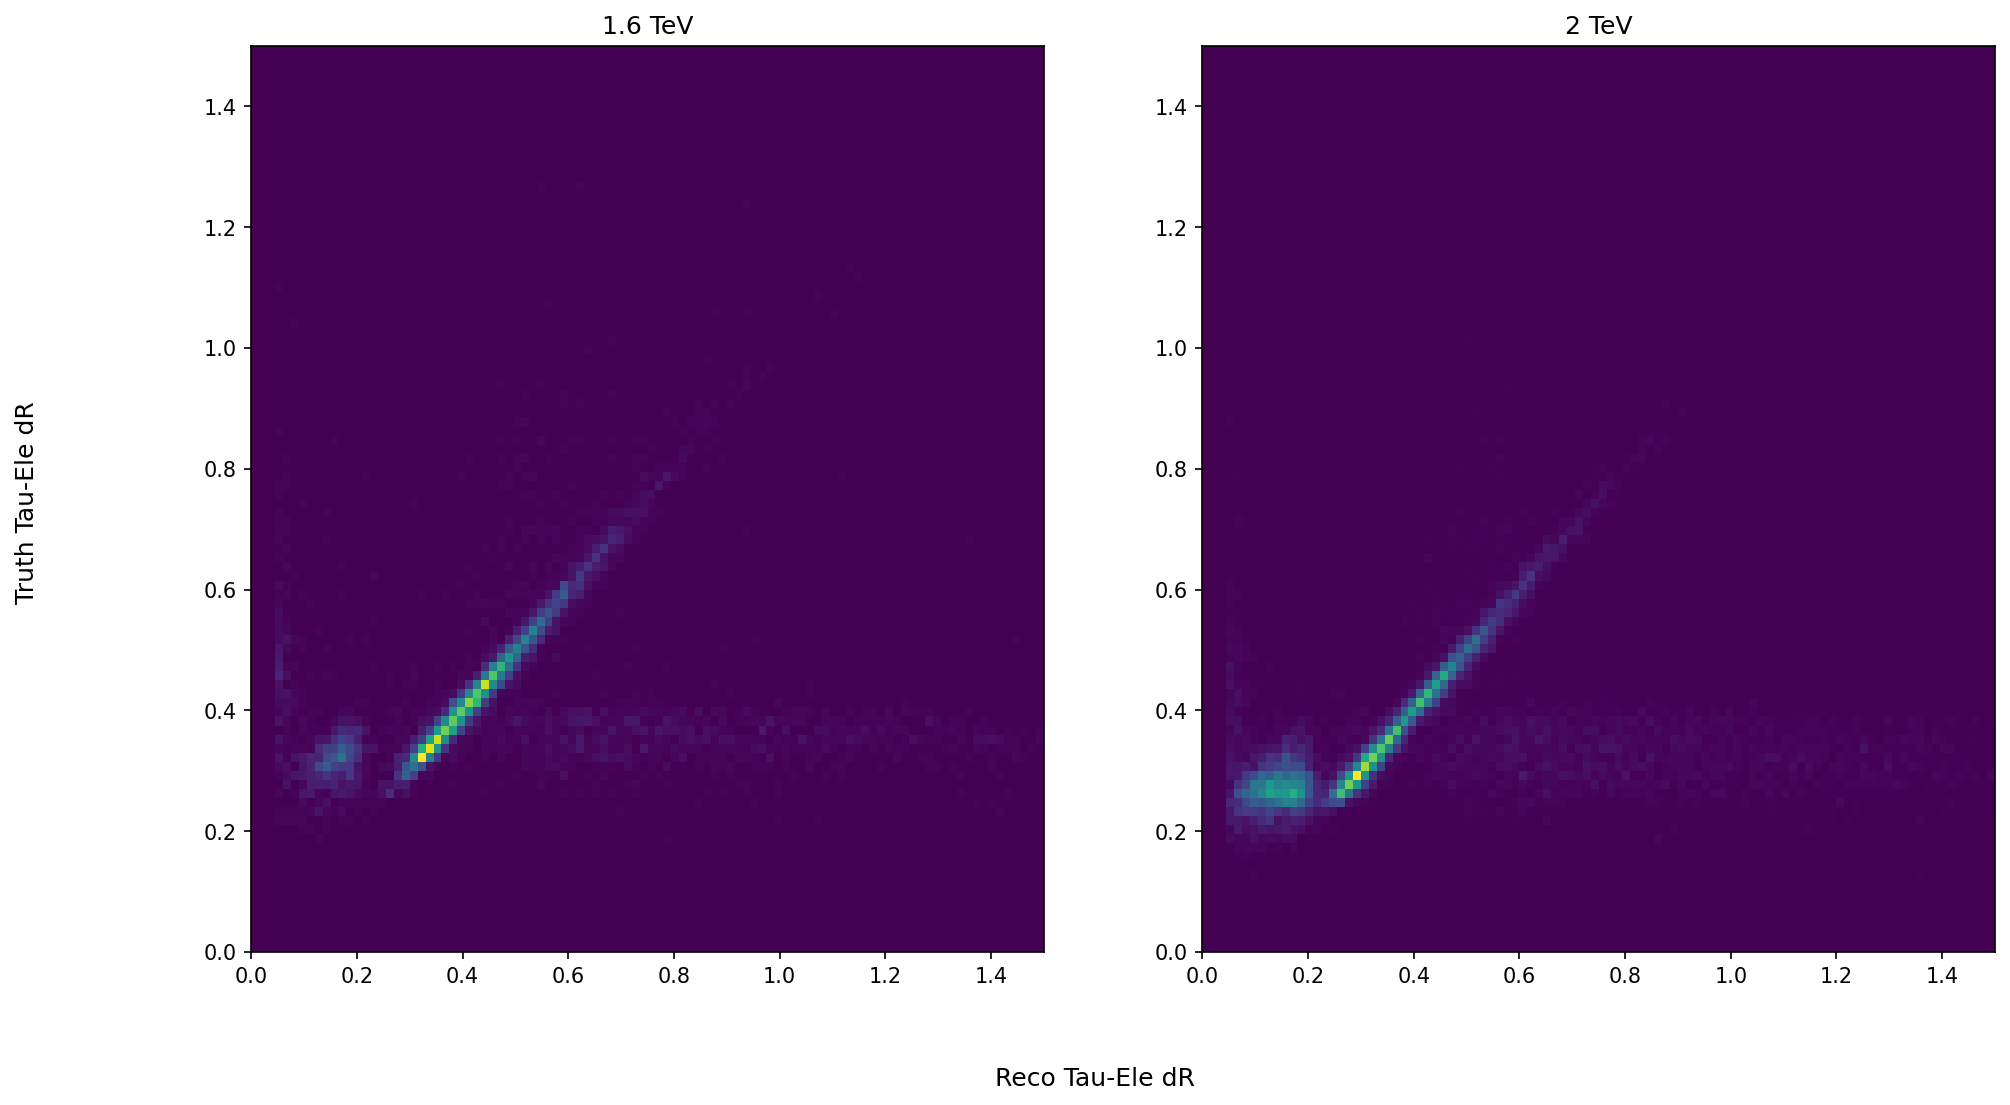

In [51]:
min_dr = 0.05

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 150

figs, axs = plt.subplots(1, 2)

plot_tau_reco_truth_comp_dr(fid_sig16tev_branches, min_dr, axs[0])
axs[0].set_title('1.6 TeV')
plot_tau_reco_truth_comp_dr(fid_sig20tev_branches, min_dr, axs[1])
axs[1].set_title('2 TeV')
figs.supylabel('Truth Tau-Ele dR')
figs.supxlabel('Reco Tau-Ele dR')
plt.show()

In [52]:
dr = 0.2
xvalues = np.arange(0, 0.2, .01)
#print(reco_truth_diff_dr(fid_sig16tev_branches, dr))
#print(reco_truth_diff_dr(fid_sig20tev_branches, dr))
sig16tev_means, sig16tev_stds = zip(*[reco_truth_diff_dr(fid_sig16tev_branches, dr) for dr in xvalues])
sig20tev_means, sig20tev_stds = zip(*[reco_truth_diff_dr(fid_sig20tev_branches, dr) for dr in xvalues])

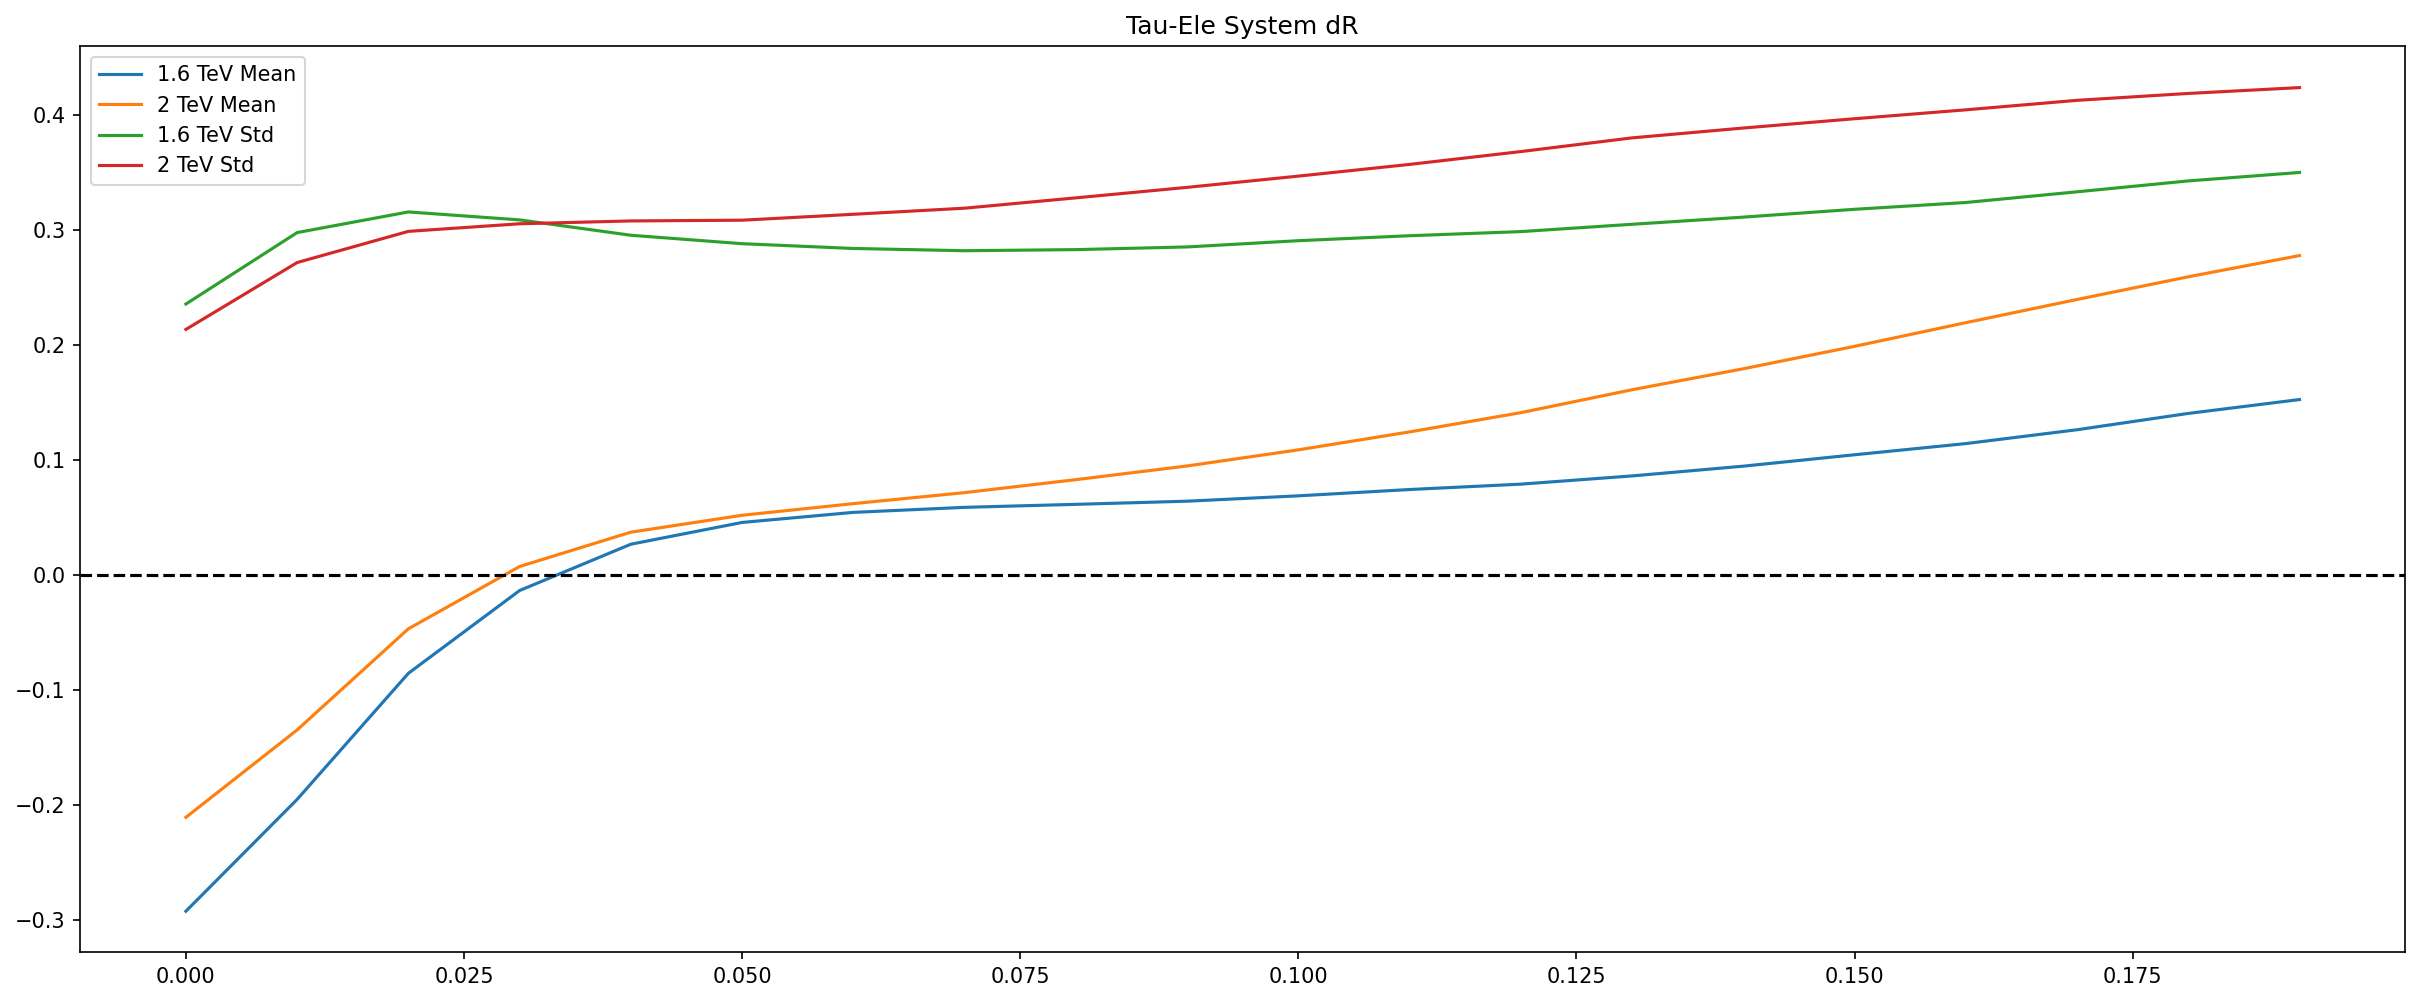

In [53]:
plt.plot(xvalues, sig16tev_means, label='1.6 TeV Mean')
plt.plot(xvalues, sig20tev_means, label='2 TeV Mean')
plt.plot(xvalues, sig16tev_stds, label='1.6 TeV Std')
plt.plot(xvalues, sig20tev_stds, label='2 TeV Std')
plt.title('Tau-Ele System dR')
plt.axhline(0, color='black', ls='--')
plt.legend()
plt.show()

## Selection Efficiencies within dR = 0.1

In [53]:
def calculate_chosen_efficiencies(true_p4s, chosen_p4s):
    passed = 0
    max_dr = 0.1
    for true_p4, chosen_p4 in zip(true_p4s, chosen_p4s):
        if chosen_p4 == 0:
            continue
        else:
            dr = true_p4.delta_r(chosen_p4)
            if dr < max_dr:
                passed += 1
            
    return (passed / len(true_p4s))

## Boosted

In [9]:
def event_eletau_selection(event_branches):
    # Get all of the objects that we need
    ditaus = create_p4s_branch(event_branches, 'HadElDiTau')
    ditau_bdt_scores = event_branches['HadElDiTauBDTScore']
    ditau_taus = create_p4s_branch(event_branches, 'HadElTau')
    ditau_electrons = create_p4s_branch(event_branches, 'HadElElectron')
    electrons = create_p4s_branch(event_branches, 'Ele')
    loose_electrons = create_p4s_branch(event_branches, 'EleLoose')
    true_electron = create_p4s_branch(event_branches, 'TruthFinalLepton')
    taus = create_p4s_branch(event_branches, 'Tau')
    true_tau = create_p4s_branch(event_branches, 'TruthHadTauVis')
    
#     print(loose_electrons.pt)
#     print(ditau_electrons.pt)
    
    chosen_electron = 0
    chosen_tau = 0
    
    # Step A: Find leading loose electron
    if len(loose_electrons) > 0:
        #print('Step A')

        loose_electrons_by_pt = [electron for electron in sorted(loose_electrons, key = lambda x: x.pt)]
        leading_electron = loose_electrons_by_pt[-1]
        #leading_electron_index = list(loose_electrons.pt).index(max(loose_electrons.pt))
        #leading_electron = loose_electrons[leading_electron_index]
        chosen_electron = leading_electron

    # Step B: Find nearest tau to electron
    if chosen_electron != 0 and len(taus) > 0:
        #print('Step B')

        electron_tau_drs = [chosen_electron.delta_r(tau) for tau in taus]
        taus_by_dr = [tau for _, tau in sorted(zip(electron_tau_drs, taus))]
        chosen_tau = taus_by_dr[0]

    # Step C: If nearest tau within 0.1 and another tau with 0.1 < dR < 1.0 and pt > 20 GeV exists
    if chosen_electron != 0 and len(taus) > 0 and sorted(electron_tau_drs)[0] < 0.1:
        # Get dR, tau pairs within 0.1 < dR < 1.0 and pt > 20 GeV, min dR to prevent self-selection
        restr_dr_tau_pairs = [[chosen_electron.delta_r(tau), tau] for tau in taus if 0.1 < chosen_electron.delta_r(tau) < 1 and tau.pt > 20]
        # Sort the taus by smallest dR
        taus_by_restr_dr = [tau for _, tau in sorted(restr_dr_tau_pairs)]
        if len(taus_by_restr_dr) > 0:
            chosen_tau = taus_by_restr_dr[0]

    # Step D: If no other suitable tau was found but there is another loose electron within 1.0 then switch to that
    if chosen_electron != 0 and sorted(electron_tau_drs)[0] < 0.1 and len(taus_by_restr_dr) == 0:
        # If no other tau found, look for other loose electron within  0.1 < dR < 1.0 (min is to avoid self-selection)
        close_loose_ele_dr_pairs = [[chosen_electron.delta_r(electron), electron] for electron in loose_electrons if 0.1 < chosen_electron.delta_r(electron) < 1]
        eles_by_dr = [electron for _, electron in sorted(close_loose_ele_dr_pairs)]
        if len(eles_by_dr) > 0:
            chosen_electron = eles_by_dr[0]

    # Get dR of currently selected electron and tau
    if chosen_electron and chosen_tau:
        current_electron_tau_dr = chosen_electron.delta_r(chosen_tau)
    # Step E: If electron and tau still within 0.2, look for a ditau with an electron overlapping the currently found electron
    if chosen_electron and chosen_tau and current_electron_tau_dr < 0.2:
        # Find all indices of ditaus whose electron is within 0.1 of current electron
        close_ditau_electron_indices = [j for j, ditau_electron in enumerate(ditau_electrons) if ditau_electron.pt == chosen_electron.pt]
        # Only continue if we found at least one ditau
        if len(close_ditau_electron_indices) > 0:
            #close_ditaus = ditaus[close_ditau_electron_indices]
            close_ditau_bdt_scores = ditau_bdt_scores[close_ditau_electron_indices]
            # Order the indices according to the ditau pt
            #close_ditau_indices_ordered = [index for _,index in sorted(zip(close_ditaus, close_ditau_electron_indices), key=lambda x:x[0].pt)]
            close_ditau_indices_ordered = [index for _,index in sorted(zip(close_ditau_bdt_scores, close_ditau_electron_indices))]
            # Choose last in ordering = highest pt
            chosen_ditau_index = close_ditau_indices_ordered[-1]
            # Select ditau objects with final index and assign to chosen variables
            chosen_ditau = ditaus[chosen_ditau_index]
            chosen_tau = ditau_taus[chosen_ditau_index]
            chosen_electron = ditau_electrons[chosen_ditau_index]
            
    return chosen_tau, chosen_electron

def selection_efficiencies(branches):
    # Get all of the objects that we need
    all_ditaus = create_p4s_branch(branches, 'HadElDiTau')
    all_ditau_bdt_scores = branches['HadElDiTauBDTScore']
    all_ditau_taus = create_p4s_branch(branches, 'HadElTau')
    all_ditau_electrons = create_p4s_branch(branches, 'HadElElectron')
    all_electrons = create_p4s_branch(branches, 'Ele')
    all_loose_electrons = create_p4s_branch(branches, 'EleLoose')
    all_true_electron = create_p4s_branch(branches, 'TruthFinalLepton')
    all_taus = create_p4s_branch(branches, 'Tau')
    all_true_tau = create_p4s_branch(branches, 'TruthHadTauVis')
    chosen_ditau_z = [0] * len(branches)
    chosen_electron_z = [0] * len(branches)
    chosen_tau_z = [0] * len(branches)
    chosen_electron_a = [0] * len(branches)
    chosen_tau_a = [0] * len(branches)
    chosen_electron_b = [0] * len(branches)
    chosen_tau_b = [0] * len(branches)
    chosen_electron_c = [0] * len(branches)
    chosen_tau_c = [0] * len(branches)
    chosen_electron_d = [0] * len(branches)
    chosen_tau_d = [0] * len(branches)
    chosen_electron_e = [0] * len(branches)
    chosen_tau_e = [0] * len(branches)
    
    # Loop over events
    for i, event_branches in enumerate(branches):
        #print(i)
        # Get the object for this event
        ditaus = all_ditaus[i]
        ditau_bdt_scores = all_ditau_bdt_scores[i]
        ditau_taus = all_ditau_taus[i]
        ditau_electrons = all_ditau_electrons[i]
        electrons = all_electrons[i]
        loose_electrons = all_loose_electrons[i]
        true_electron = all_true_electron[i]
        taus = all_taus[i]
        true_tau = all_true_tau[i]
        
        # Step A: Find leading loose electron
        if len(loose_electrons) > 0:
            #print('Step A')
            
            loose_electrons_by_pt = [electron for electron in sorted(loose_electrons, key = lambda x: x.pt)]
            leading_electron = loose_electrons_by_pt[-1]
            #leading_electron_index = list(loose_electrons.pt).index(max(loose_electrons.pt))
            #leading_electron = loose_electrons[leading_electron_index]
            chosen_electron_a[i] = leading_electron
        
        chosen_tau_b[i] = chosen_tau_a[i]
        chosen_electron_b[i] = chosen_electron_a[i]
        # Step B: Find nearest tau to electron
        if chosen_electron_a[i] != 0 and len(taus) > 0:
            #print('Step B')
            
            electron_tau_drs = [chosen_electron_a[i].delta_r(tau) for tau in taus]
            taus_by_dr = [tau for _, tau in sorted(zip(electron_tau_drs, taus))]
            chosen_tau_b[i] = taus_by_dr[0]
        
        chosen_tau_c[i] = chosen_tau_b[i]
        chosen_electron_c[i] = chosen_electron_b[i]
        # Step C: If nearest tau within 0.1 and another tau with 0.1 < dR < 1.0 and pt > 20 GeV exists
        if chosen_electron_c[i] != 0 and len(taus) > 0 and sorted(electron_tau_drs)[0] < 0.1:
            # Get dR, tau pairs within 0.1 < dR < 1.0 and pt > 20 GeV, min dR to prevent self-selection
            restr_dr_tau_pairs = [[chosen_electron_c[i].delta_r(tau), tau] for tau in taus if 0.1 < chosen_electron_c[i].delta_r(tau) < 1 and tau.pt > 20]
            # Sort the taus by smallest dR
            taus_by_restr_dr = [tau for _, tau in sorted(restr_dr_tau_pairs)]
            if len(taus_by_restr_dr) > 0:
                chosen_tau_c[i] = taus_by_restr_dr[0]
             
        chosen_tau_d[i] = chosen_tau_c[i]
        chosen_electron_d[i] = chosen_electron_c[i]
        # Step D: If no other suitable tau was found but there is another loose electron within 1.0 then switch to that
        if chosen_electron_d[i] != 0 and sorted(electron_tau_drs)[0] < 0.1 and len(taus_by_restr_dr) == 0:
            # If no other tau found, look for other loose electron within  0.1 < dR < 1.0 (min is to avoid self-selection)
            close_loose_ele_dr_pairs = [[chosen_electron_d[i].delta_r(electron), electron] for electron in loose_electrons if 0.1 < chosen_electron_d[i].delta_r(electron) < 1]
            eles_by_dr = [electron for _, electron in sorted(close_loose_ele_dr_pairs)]
            if len(eles_by_dr) > 0:
                chosen_electron_d[i] = eles_by_dr[0]
                
        chosen_tau_e[i] = chosen_tau_d[i]
        chosen_electron_e[i] = chosen_electron_d[i]
        # Get dR of currently selected electron and tau
        if chosen_electron_e[i] and chosen_tau_e[i]:
            current_electron_tau_dr = chosen_electron_e[i].delta_r(chosen_tau_e[i])
        # Step E: If electron and tau still within 0.2, look for a ditau with an electron overlapping the currently found electron
        if chosen_electron_e[i] and chosen_tau_e[i] and current_electron_tau_dr < 0.2:
            # Find all indices of ditaus whose electron is within 0.1 of current electron
            close_ditau_electron_indices = [j for j, ditau_electron in enumerate(ditau_electrons) if ditau_electron.delta_r(chosen_electron_e[i]) < 0.1]
            # Only continue if we found at least one ditau
            if len(close_ditau_electron_indices) > 0:
                #close_ditaus = ditaus[close_ditau_electron_indices]
                close_ditau_bdt_scores = ditau_bdt_scores[close_ditau_electron_indices]
                # Order the indices according to the ditau pt
                #close_ditau_indices_ordered = [index for _,index in sorted(zip(close_ditaus, close_ditau_electron_indices), key=lambda x:x[0].pt)]
                close_ditau_indices_ordered = [index for _,index in sorted(zip(close_ditau_bdt_scores, close_ditau_electron_indices))]
                # Choose last in ordering = highest pt
                chosen_ditau_index = close_ditau_indices_ordered[-1]
                # Select ditau objects with final index and assign to chosen variables
                chosen_ditau = ditaus[chosen_ditau_index]
                chosen_tau_e[i] = ditau_taus[chosen_ditau_index]
                chosen_electron_e[i] = ditau_electrons[chosen_ditau_index]
            
    print('Efficiencies after selecting leading loose electron')
    print(calculate_chosen_efficiencies(all_true_electron, chosen_electron_a))
    print(calculate_chosen_efficiencies(all_true_tau, chosen_tau_a))
    print('')
    
    print('Efficiencies after selecting closest tau to electron')
    print(calculate_chosen_efficiencies(all_true_electron, chosen_electron_b))
    print(calculate_chosen_efficiencies(all_true_tau, chosen_tau_b)) 
    print('')    

    print('Efficiencies after restricting tau-ele dR to 0.1 - 1 and pt > 20 GeV')
    print(calculate_chosen_efficiencies(all_true_electron, chosen_electron_c))
    print(calculate_chosen_efficiencies(all_true_tau, chosen_tau_c)) 
    print('')
    
    print('Efficiencies after switching to other loose electron within 1.0 if no other tau found')
    print(calculate_chosen_efficiencies(all_true_electron, chosen_electron_d))
    print(calculate_chosen_efficiencies(all_true_tau, chosen_tau_d)) 
    print('')
    
    print('Efficiencies after finding ditau with overlapping electron if dR < 0.2')
    print(calculate_chosen_efficiencies(all_true_electron, chosen_electron_e))
    print(calculate_chosen_efficiencies(all_true_tau, chosen_tau_e)) 

In [ ]:
boosted_tracker = DiTauEfficiencyTracker(sig16_sample.fid_hadel_branches, 'HadEl')
branches = sig16_sample.fid_hadel_branches
all_leading_ele_loose = create_p4s_branch(branches, 'LeadingEleLoose')
all_ele_loose = create_p4s_branch(branches, 'EleLoose')

for i, event_branches in enumerate(branches):
    leading_ele_loose = create_p4s_branch(event_branches, 'LeadingEleLoose')
    ele_loose = create_p4s_branch(event_branches, 'EleLoose')
    leading_tau = create_p4s_branch(event_branches, 'LeadingTau')
    leading_ele = create_p4s_branch(event_branches, 'LeadingEle')
    chosen_ele = 0
    chosen_tau = 0
    if len(ele_loose) > 0:
        chosen_ele = leading_ele_loose[0]

    boosted_tracker.checkpoint('Leading loose electron', chosen_ele, chosen_tau)
        
    if len(ele_loose) == 0:
        chosen_ele = leading_ele[0]
    
    boosted_tracker.checkpoint('No loose, choose leading', chosen_ele, chosen_tau)
        
boosted_tracker.summarize()

4
-2.1104283332824707
-2.1610472202301025
-2.1609559059143066
[-2.16, -2.9]
0.018205461638491547


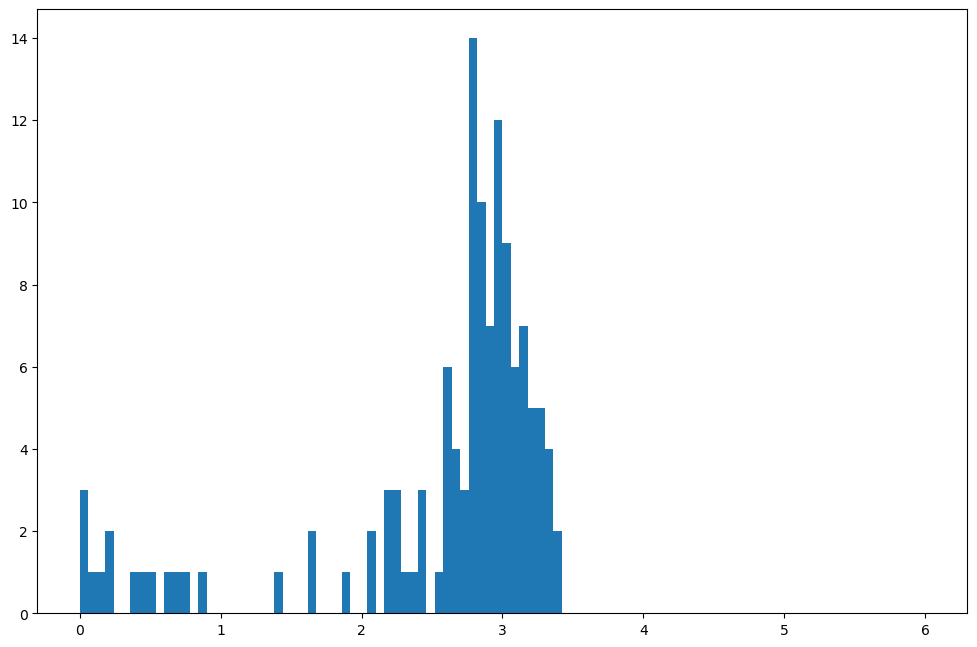

In [50]:
def hadel_btagging(branches):
    selection = Selection()
    selection.set_cut('NBTagJet', 1, 'min')
    selection.set_cut('NEleLoose', 2, 'min')
    valid_branches = selection.apply_cuts_to_branches(branches)
    
    leading_btag_jet = create_p4s_branch(valid_branches, 'LeadingBTagJet')
    chosen_ele = create_p4s_branch(valid_branches, 'ChosenEle')
    drs = leading_btag_jet.delta_r(chosen_ele)
    
    plt.hist(drs, 100, [0, 6])
    
    filtered_branches = valid_branches[drs < 0.1]
    
    print(len(filtered_branches))
    i = 3
    print(filtered_branches[i]['LeadingBTagJetPhi'])
    print(filtered_branches[i]['ChosenElePhi'])
    print(filtered_branches[i]['TruthFinalLeptonPhi'])
    print(filtered_branches[i]['EleLoosePhi'])
    
    return sum(drs < 1) / len(branches)    
    
    
    returnn sum(drs < 1) / len(branches)
    
print(hadel_btagging(sig10_sample.fid_hadel_branches))

# HadMu

In [42]:
print('Percentage of events with all relevant reco objects (Large-R jets, loose electrons, taus*)')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    hadmu_mask = boosted_hadmu_object_mask(branches)
    lrjet_mask = object_mask(branches, 'LargeRHbbJet')
    all_masks = [hadmu_mask, lrjet_mask]
    event_mask = ak.all(all_masks, axis=0)
    eff = sum(event_mask) / len(branches)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with all relevant reco objects (Large-R jets, loose electrons, taus*)

1 TeV
99.3%

1.6 TeV
99.3%

2 TeV
99.1%



In [43]:
print('Percentage of events with reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    event_mask = hadmu_whole_tm_event_mask(branches)
    eff = sum(event_mask) / len(branches)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with reco objects close to truth objects

1 TeV
85.8%

1.6 TeV
93.0%

2 TeV
92.3%



In [48]:
print('Percentage of events with selected reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    event_mask = hadmu_whole_selected_tm_event_mask(branches)
    eff = sum(event_mask) / len(branches)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')    

Percentage of events with selected reco objects close to truth objects

1 TeV
64.9%

1.6 TeV
81.0%

2 TeV
79.7%



In [49]:
print('Percentage of TM events with selected reco objects close to truth objects')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    whole_event_mask = hadmu_whole_tm_event_mask(branches)
    selected_whole_event_mask = hadmu_whole_selected_tm_event_mask(branches)
    eff = sum(selected_whole_event_mask) / sum(whole_event_mask)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  

Percentage of TM events with selected reco objects close to truth objects

1 TeV
75.6%

1.6 TeV
87.0%

2 TeV
86.3%



## Tight Muons

In [30]:
print('Percentage of events with at least one tight muon')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    print(sample.short_name)
    print('{:.1%}'.format(object_efficiency(branches, 'MuTight')))
    print('')

Percentage of events with at least one tight muon

1 TeV
99.3%

1.6 TeV
99.3%

2 TeV
99.1%



In [31]:
print('Percentage of events with tight muon within dR < 0.1 of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    print(sample.short_name)
    print('{:.1%}'.format(eff_truthmatch_branch(branches, 'MuTight', 'TruthFinalLepton', 0.1)))
    print('')

Percentage of events with tight muon within dR < 0.1 of truth

1 TeV
97.3%

1.6 TeV
97.0%

2 TeV
96.4%



In [32]:
max_dr = 0.1
print('Percentage of events whose leading tight muon is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = frac_leading_reco_close_to_truth(branches, 'MuTight', 'TruthFinalLepton', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events whose leading tight muon is within 0.1 of truth electron

1 TeV
93.4%

1.6 TeV
92.4%

2 TeV
91.2%



In [35]:
max_dr = 0.1
print('Percentage of truth-matched events whose leading tight muon is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = frac_tm_is_leading_reco(branches, 'MuTight', 'TruthFinalLepton', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of truth-matched events whose leading tight muon is within 0.1 of truth electron

1 TeV
96.0%

1.6 TeV
95.2%

2 TeV
94.6%



### Chosen muon

In [24]:
max_dr = 0.1
print('Percentage of truth-matched events whose chosen muon is within {} of truth electron'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = frac_tm_is_chosen_muon(branches, max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of truth-matched events whose chosen muon is within 0.1 of truth electron

1 TeV
96.0%

1.6 TeV
95.2%

2 TeV
94.6%



## Tau-Mu System

In [38]:
max_dr = 0.1
print(f'Percentage of events with a tight muon within {max_dr} of truth muon and tau/subjet within {max_dr} of truth tau')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = boosted_hadmu_tm_eff(branches, max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with a tight muon within 0.1 of truth muon and tau/subjet within 0.1 of truth tau

1 TeV
96.9%

1.6 TeV
96.1%

2 TeV
95.0%



In [41]:
max_dr = 0.1
print('Percentage of events with both chosen objects lying within dR < 0.1 of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    hadmu_mask = chosen_hadmu_close_to_truth_mask(branches, max_dr)
    both_eff = sum(hadmu_mask) / len(branches)
    muon_eff, tau_eff = chosen_boosted_mutau_efficiencies(branches)
    print(sample.short_name)
    print('Muon: {:.1%}'.format(muon_eff))
    print('Tau: {:.1%}'.format(tau_eff))
    print('Both: {:.1%}'.format(both_eff))
    print('')

Percentage of events with both chosen objects lying within dR < 0.1 of truth

1 TeV
Muon: 93.4%
Tau: 90.0%
Both: 90.0%

1.6 TeV
Muon: 92.4%
Tau: 89.8%
Both: 89.8%

2 TeV
Muon: 91.2%
Tau: 86.2%
Both: 86.2%



In [43]:
max_dr = 0.1
print(f'Percentage of TM events with both chosen objects within {max_dr} of truth')
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = frac_tm_is_chosen_hadmu(branches, max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of TM events with both chosen objects within 0.1 of truth

1 TeV
92.8%

1.6 TeV
93.4%

2 TeV
90.7%



### Hbb Large-R Jets

In [44]:
max_dr = 0.2
print('Percentage of events with an Hbb large-R jet within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = eff_truthmatch_branch(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events with an Hbb large-R jet within 0.2 of truth Higgs

1 TeV
88.3%

1.6 TeV
96.8%

2 TeV
97.1%



In [45]:
max_dr = 0.2
print('Percentage of events whose leading Hbb large-R jet is within {} of truth b Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = frac_leading_reco_close_to_truth(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')

Percentage of events whose leading Hbb large-R jet is within 0.2 of truth b Higgs

1 TeV
68.1%

1.6 TeV
89.5%

2 TeV
89.4%



In [6]:
max_dr = 0.2
print('Percentage of truth-matched events whose leading Hbb large-R jet is within {} of truth b Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    eff = frac_tm_is_leading_reco(branches, 'LargeRHbbJet', 'TruthBHiggs', max_dr)
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')      

Percentage of truth-matched events whose leading Hbb large-R jet is within 0.2 of truth b Higgs

1 TeV
77.1%

1.6 TeV
92.5%

2 TeV
92.1%



In [52]:
all_branches = sig10_sample.fid_hadmu_branches
max_dr = 0.2

print(len(all_branches))
tm_event_count = 0
tm_leading_count = 0
tm_offlep_count = 0
tm_higgsmass_count = 0
for i, branches in enumerate(all_branches):
    lrjet_bhiggs_drs = branch_drs(branches, 'LargeRHbbJet', 'TruthBHiggs')
    lrjet_lepton_drs = branch_drs(branches, 'LargeRHbbJet', 'HadMuChosenMu')
    lrjet_truth_lepton_drs = branch_drs(branches, 'LargeRHbbJet', 'TruthFinalLepton')
    lepton_truth_drs = branch_drs(branches, 'HadMuChosenMu', 'TruthFinalLepton')
    bhiggs_lepton_drs = branch_drs(branches, 'TruthFinalLepton', 'TruthBHiggs')
    lrjet_tau_drs = branch_drs(branches, 'LargeRHbbJet', 'TruthHadTauVis')
    lrjet_tauhiggs_drs = branch_drs(branches, 'LargeRHbbJet', 'TruthTauHiggs')
    lrjet_dihiggs_drs = branch_drs(branches, 'LargeRHbbJet', 'LargeRX')
    higgs_drs = branch_drs(branches, 'TruthBHiggs', 'TruthTauHiggs')
    truth_lep_tau_drs = branch_drs(branches, 'TruthFinalLepton', 'TruthHadTauVis')
    
    abs_masses = abs(branches['LargeRHbbJetM'] - 125)
    mass_dr_zip = zip(abs_masses, lrjet_bhiggs_drs)
    sorted_mass_drs = [x[1] for x in sorted(mass_dr_zip)]
#     print(branches['LargeRHbbJetM'])
#     print(abs_masses)
#     print(lrjet_bhiggs_drs)
#     for zippy in mass_dr_zip:
#         print(zippy)
#     print(sorted_mass_drs)
    
    leading_pts = branches['LargeRHbbJetPt'][0:2]
    lepton_drs = lrjet_lepton_drs[0:2]
    bhiggs_drs = lrjet_bhiggs_drs[0:2]
    zipper = zip(lepton_drs, bhiggs_drs)
    sorted_drs = [x[1] for x in sorted(zipper, reverse=True)]
#     print(bhiggs_drs)
#     print(lepton_drs)
#     print(sorted_drs)
#     print('')

    

    if min(lrjet_bhiggs_drs) < 0.2:
        tm_event_count += 1
    if lrjet_bhiggs_drs[0] < 0.2:
        tm_leading_count += 1
    if sorted_drs[0] < 0.2:
        tm_offlep_count += 1
    if sorted_mass_drs[0] < 0.2:
        tm_higgsmass_count += 1
    
    if i == 33:
        print('Pts')
        print(branches['LargeRHbbJetPt'])
        print('Jet-BHiggs dR')
        print(lrjet_bhiggs_drs)
        print('Jet-Lep dR')
        print(lrjet_lepton_drs)
        print('Lepton Truth dR')
        print(lepton_truth_drs)
        print('Lepton-BHiggs dR')
        print(bhiggs_lepton_drs)
        print('Jet-Tau dR')
        print(lrjet_tau_drs)
        print('Lep-Tau dR')
        print(truth_lep_tau_drs)
        print('Jet-TauHiggs dR')
        print(lrjet_tauhiggs_drs)
        print('Jet-DiHiggs dR')
        print(lrjet_dihiggs_drs)
        print('Truth Higgs dR')
        print(higgs_drs)
        print('DiHiggs Pt')
        print(branches['LargeRXPt'])
        break
        
print(tm_event_count)
print(tm_leading_count)
print(tm_offlep_count)
print(tm_higgsmass_count)

6842
Pts
[536, 481, 248, 182, 79.4, 67.2, 63.3, 52, 44.4, 41.4]
Jet-BHiggs dR
[1.09457361 2.81406778 0.16792253 2.02466615 3.86493936 1.81903961
 3.79245273 2.18959782 2.44152761 2.64635538]
Jet-Lep dR
[2.63317891 0.29745896 2.59007366 1.93192247 2.4030202  2.53850388
 3.38323192 3.46114006 1.9301579  1.27679174]
Lepton Truth dR
[0.00042378]
Lepton-BHiggs dR
[2.73888322]
Jet-Tau dR
[2.68259687 0.06484003 2.68317083 1.73217081 2.0821663  2.7794818
 3.05611533 3.32939599 1.79773005 1.63483792]
Lep-Tau dR
[0.36063724]
Jet-TauHiggs dR
[2.66158011 0.05150189 2.64906085 1.78997429 2.1819718  2.70035956
 3.15866968 3.36713364 1.83267039 1.52170686]
Jet-DiHiggs dR
[1.24458633 2.16916186 2.03020165 3.60953219 3.28627901 0.61195978
 5.0075564  2.84555489 1.90190764 1.91869597]
Truth Higgs dR
[2.78996261]
DiHiggs Pt
302.5413818359375
30
24
23
24


### Off-lepton Large-R Jet    

In [36]:
max_dr = 0.2
print('Percentage of truth-matched events whose off-lepton Hbb large-R jet is within {} of truth Higgs'.format(max_dr))
print('')
for sample in signal_samples:
    branches = sample.fid_hadmu_branches
    
    event_tm_mask = get_tm_event_mask(branches, 'LargeRHbbJet', 'TruthBHiggs', 0.2)
    event_tm_branches = branches[event_tm_mask]
    dr_mask = event_tm_branches['HadMuLargeRHbbJetTruthdR'] < 0.2
    dr_branches = event_tm_branches[dr_mask]
    eff = len(dr_branches) / len(event_tm_branches)
    
    print(sample.short_name)
    print('{:.1%}'.format(eff))
    print('')  

Percentage of truth-matched events whose off-lepton Hbb large-R jet is within 0.2 of truth Higgs

1 TeV
76.4%

1.6 TeV
86.7%

2 TeV
86.6%



## B-tag Jets

In [10]:
print('Percentage of events with at least one btag jet')
print('')
print('1 TeV')
print('{:.1%}'.format(btag_efficiency(sig10_sample.fid_hadmu_branches)))
print('')
print('1.6 TeV')
print('{:.1%}'.format(btag_efficiency(sig16_sample.fid_hadmu_branches)))
print('')
print('2 TeV')
print('{:.1%}'.format(btag_efficiency(sig20_sample.fid_hadmu_branches)))

Percentage of events with at least one btag jet

1 TeV
92.1%

1.6 TeV
84.9%

2 TeV
80.6%


In [54]:
print('Percentage of events with a btag jet within dR < 0.1 of truth bs')
print('')
print('1 TeV')
sig10_btag_effs = get_frac_bs_close_to_truth(sig10_sample.fid_hadel_branches)
print('B: {:.1%}  Anti-B: {:.1%}  Either: {:.1%}  Both: {:.1%}'.format(sig10_btag_effs[0], sig10_btag_effs[1], sig10_btag_effs[2], sig10_btag_effs[3]))
print('1.6 TeV')
sig16_btag_effs = get_frac_bs_close_to_truth(sig16_sample.fid_hadel_branches)
print('B: {:.1%}  Anti-B: {:.1%}  Either: {:.1%}  Both: {:.1%}'.format(sig16_btag_effs[0], sig16_btag_effs[1], sig16_btag_effs[2], sig16_btag_effs[3]))
print('2 TeV')
sig20_btag_effs = get_frac_bs_close_to_truth(sig20_sample.fid_hadel_branches)
print('B: {:.1%}  Anti-B: {:.1%}  Either: {:.1%}  Both: {:.1%}'.format(sig20_btag_effs[0], sig20_btag_effs[1], sig20_btag_effs[2], sig20_btag_effs[3]))

Percentage of events with a btag jet within dR < 0.1 of truth bs

1 TeV
B: 62.4%  Anti-B: 60.9%  Either: 83.1%  Both: 40.2%
1.6 TeV
B: 34.0%  Anti-B: 34.9%  Either: 52.2%  Both: 16.6%
2 TeV
B: 31.5%  Anti-B: 32.2%  Either: 53.9%  Both: 9.8%


In [22]:
dr = 0.2
print('Percentage of events with leading btag jet within dR < {} of either truth b'.format(dr))
print('1 TeV')
print('{:.1%}'.format(get_frac_leading_btag_close_to_truth(sig10_sample.fid_hadmu_branches, dr)))
print('')
print('1.6 TeV')
print('{:.1%}'.format(get_frac_leading_btag_close_to_truth(sig16_sample.fid_hadmu_branches, dr)))
print('')
print('2 TeV')
print('{:.1%}'.format(get_frac_leading_btag_close_to_truth(sig20_sample.fid_hadmu_branches, dr)))

Percentage of events with leading btag jet within dR < 0.2 of either truth b
1 TeV
82.3%

1.6 TeV
78.0%

2 TeV
73.0%


14


ValueError: in IndexedArray64 attempting to get 14, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.0.2/src/libawkward/array/IndexedArray.cpp#L1146)

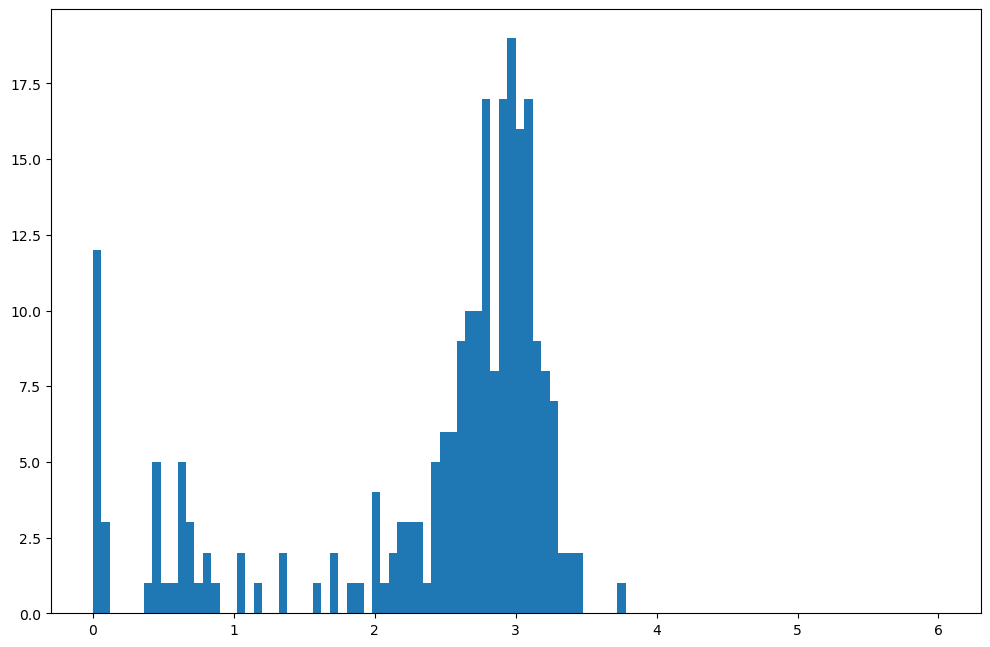

In [9]:
def hadmu_btagging(branches):
    selection = Selection()
    selection.set_cut('NBTagJet', 1, 'min')
    selection.set_cut('NMuTight', 2, 'min')
    valid_branches = selection.apply_cuts_to_branches(branches)
    
    leading_btag_jet = create_p4s_branch(valid_branches, 'LeadingBTagJet')
    chosen_mu = create_p4s_branch(valid_branches, 'ChosenMu')
    drs = leading_btag_jet.delta_r(chosen_mu)
    
    plt.hist(drs, 100, [0, 6])
    
    filtered_branches = valid_branches[drs < 0.1]
    
    print(len(filtered_branches))
    i = 14
    print(filtered_branches[i]['LeadingBTagJetPhi'])
    print(filtered_branches[i]['ChosenMuPhi'])
    print(filtered_branches[i]['TruthFinalLeptonPhi'])
    print(filtered_branches[i]['MuTightPhi'])
    
    return sum(drs < 1) / len(branches)
    
print(hadmu_btagging(sig10_sample.fid_hadmu_branches))   

## True dR (eHad)

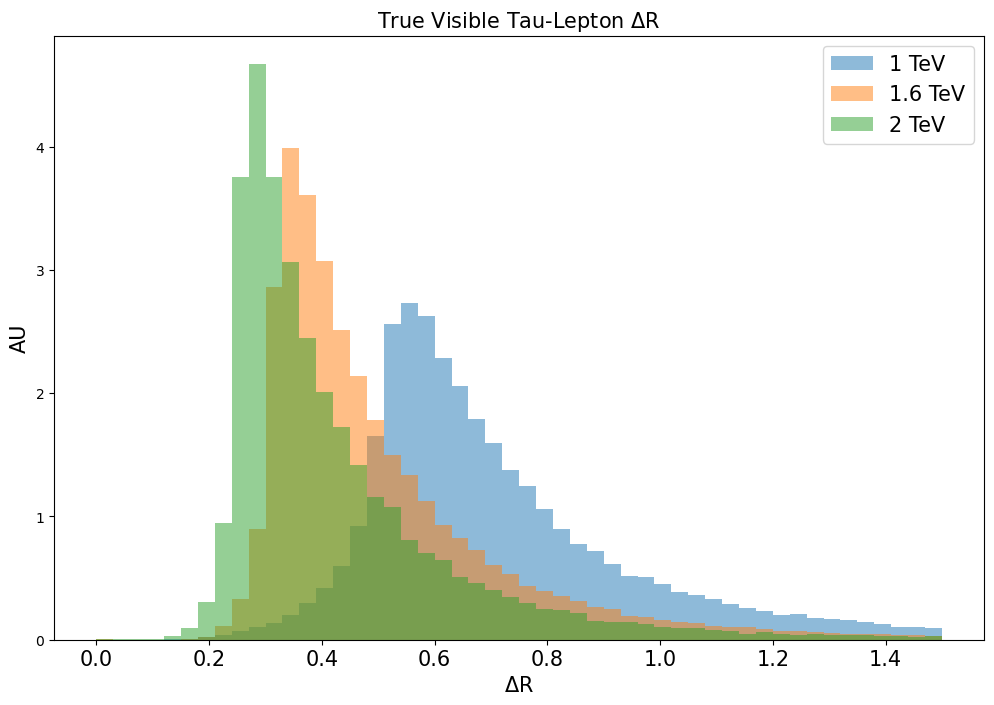

In [9]:
create_normed_hist(sig10_sample.branches['TruthHadTauVisFinalLeptondR'], 50, 0, 1.5, '1 TeV')
create_normed_hist(sig16_sample.branches['TruthHadTauVisFinalLeptondR'], 50, 0, 1.5, '1.6 TeV')
create_normed_hist(sig20_sample.branches['TruthHadTauVisFinalLeptondR'], 50, 0, 1.5, '2 TeV')
plt.title('True Visible Tau-Lepton $\Delta$R', size=15)
plt.xlabel('$\Delta$R', size=15)
plt.xticks(size=15)
plt.ylabel('AU', size=15)
#plt.text(1.0, 3, 'eHad events', size=15)
plt.legend(fontsize=15)
plt.show()

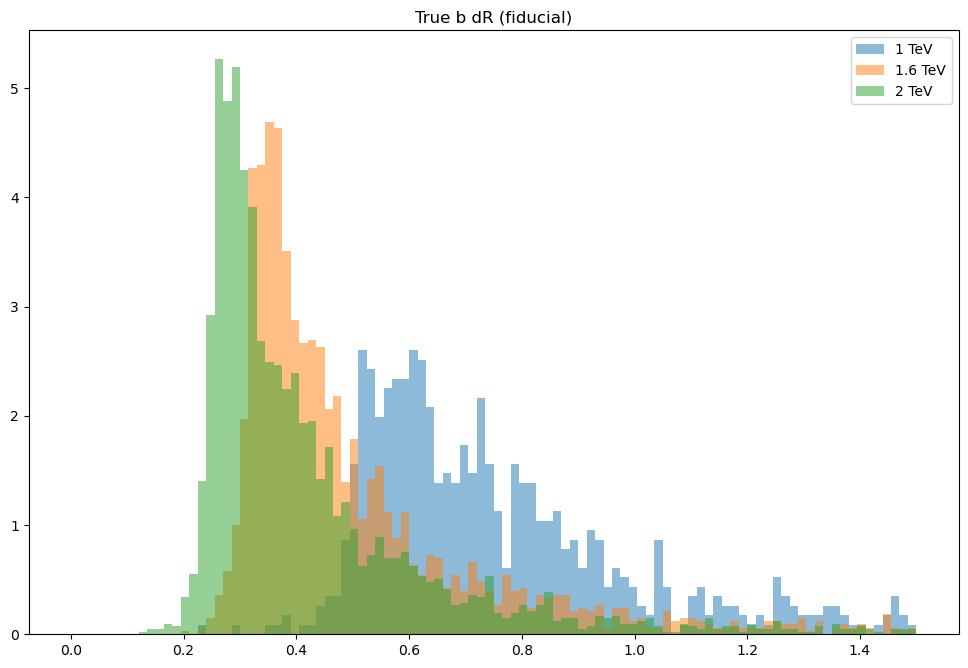

In [4]:
create_normed_hist(sig10_sample.fid_hadel_branches['TruthBdR'], 100, 0, 1.5, '1 TeV')
create_normed_hist(sig16_sample.fid_hadel_branches['TruthBdR'], 100, 0, 1.5, '1.6 TeV')
create_normed_hist(sig20_sample.fid_hadel_branches['TruthBdR'], 100, 0, 1.5, '2 TeV')
plt.title('True b dR (fiducial)')
plt.legend()
plt.show()

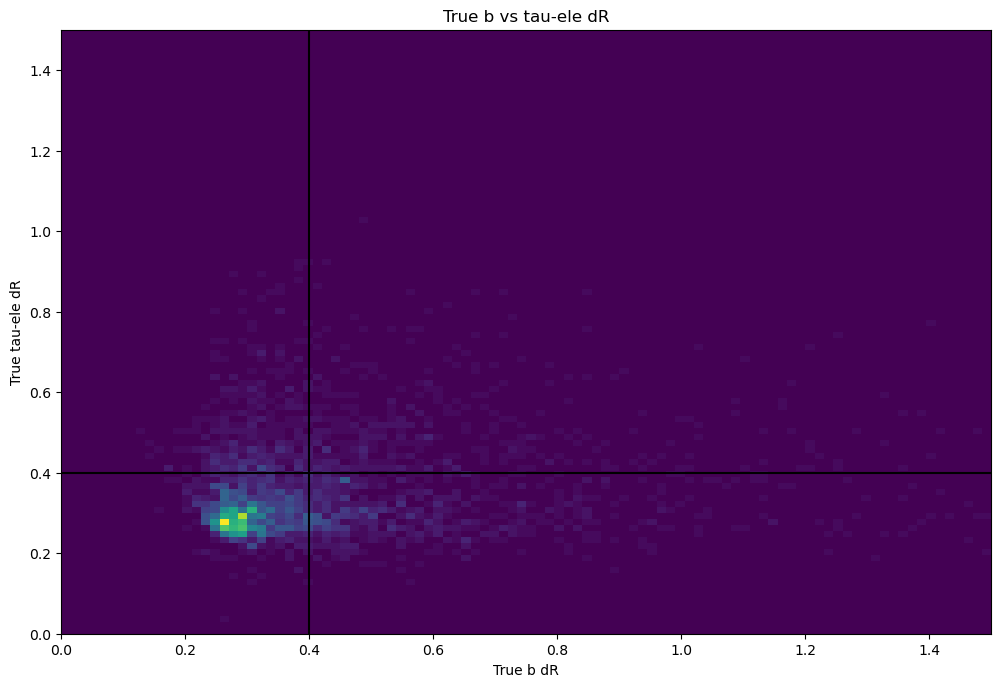

In [13]:
norm_bdr_vals = np.array(sig20_sample.fid_hadel_branches['TruthBdR'])
norm_taudr_vals = np.array(sig20_sample.fid_hadel_branches['TruthHadTauVisFinalLeptondR'])
plt.hist2d(norm_bdr_vals, norm_taudr_vals, 100, [[0,1.5], [0,1.5]], density=True)
plt.axhline(0.4, color='black')
plt.axvline(0.4, color='black')
plt.xlabel('True b dR')
plt.ylabel('True tau-ele dR')
plt.title('True b vs tau-ele dR')
plt.show()

In [15]:
threshold_dr = 0.3
tau_boosted_mask = sig20_sample.hadel_branches['TruthHadTauVisFinalLeptondR'] < threshold_dr
b_boosted_mask = sig20_sample.hadel_branches['TruthBdR'] < threshold_dr
both_boosted_mask = ak.all([tau_boosted_mask, b_boosted_mask], axis=0)
either_boosted_mask = ak.any([tau_boosted_mask, b_boosted_mask], axis=0)

total_events = len(sig20_sample.hadel_branches)
print('Boosted on tau side: {}'.format(sum(tau_boosted_mask) / total_events))
print('Boosted on b side: {}'.format(sum(b_boosted_mask) / total_events))
print('Boosted on either sides: {}'. format(sum(either_boosted_mask) / total_events))
print('Boosted on both sides: {}'. format(sum(both_boosted_mask) / total_events))

Boosted on tau side: 0.28436114469971785
Boosted on b side: 0.2730753728335349
Boosted on either sides: 0.447198710197501
Boosted on both sides: 0.11023780733575171


In [18]:
def eff_by_true_dr(branches, selection, label):
    presel_branches = selection.apply_cuts_to_branches(branches)

    before_drs = np.array(branches['TruthHadTauVisFinalLeptondR'])
    after_drs = np.array(presel_branches['TruthHadTauVisFinalLeptondR'])

    low_dr = 0
    high_dr = 2
    steps = 20
    step_width = (high_dr - low_dr) / steps
    eff_hist = create_eff_histograms(after_drs, before_drs, low_dr, high_dr, steps)
    drs = np.arange(low_dr, high_dr, step_width)
    plt.step(drs, eff_hist, label=label)

In [19]:
print(len(sig10_sample.hadel_branches))

35790


/eos/home-i00/n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:304: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)


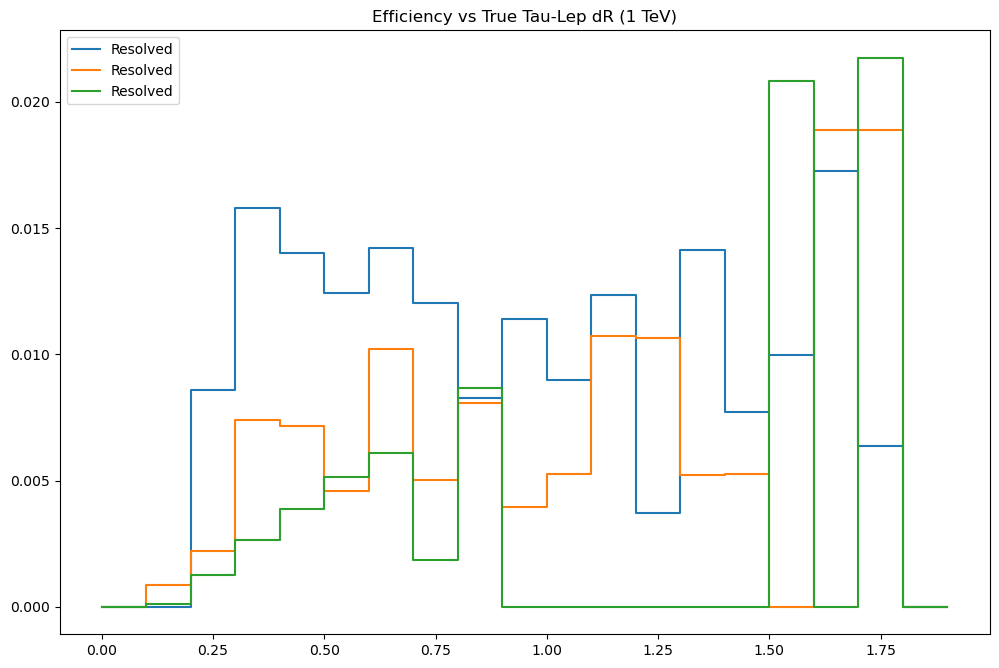

In [20]:
#eff_by_true_dr(sig10_sample.fid_hadel_branches, boosted_hadel_selection(), 'Boosted (fiducial)')
#eff_by_true_dr(sig10_sample.hadel_branches, boosted_hadel_selection(), 'Boosted')
#eff_by_true_dr(sig16_sample.fid_hadel_branches, boosted_hadel_selection())
#eff_by_true_dr(sig20_sample.fid_hadel_branches, boosted_hadel_selection())
eff_by_true_dr(sig10_sample.hadel_branches, resolved_selection(), 'Resolved')
eff_by_true_dr(sig16_sample.hadel_branches, resolved_selection(), 'Resolved')
eff_by_true_dr(sig20_sample.hadel_branches, resolved_selection(), 'Resolved')
plt.legend()
plt.title('Efficiency vs True Tau-Lep dR (1 TeV)') 
plt.show()

In [22]:
def eff_from_drs(before_drs, after_drs, label):
    low_dr = 0
    high_dr = 1.2
    steps = 25
    step_width = (high_dr - low_dr) / steps
    eff_hist = create_eff_histograms(after_drs, before_drs, low_dr, high_dr, steps)
    drs = np.arange(low_dr, high_dr, step_width)
    plt.step(drs, eff_hist, label=label)

/eos/home-n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:301: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)
/eos/home-n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:301: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)
/eos/home-n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:301: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)
/eos/home-n/nicholas/SWAN_projects/DiTauReco/scripts/bbtautau_helpers.py:301: RuntimeWarning: invalid value encountered in true_divide
  eff_hist = np.divide(num_hist, denom_hist)


<class 'awkward.highlevel.Array'>
1855


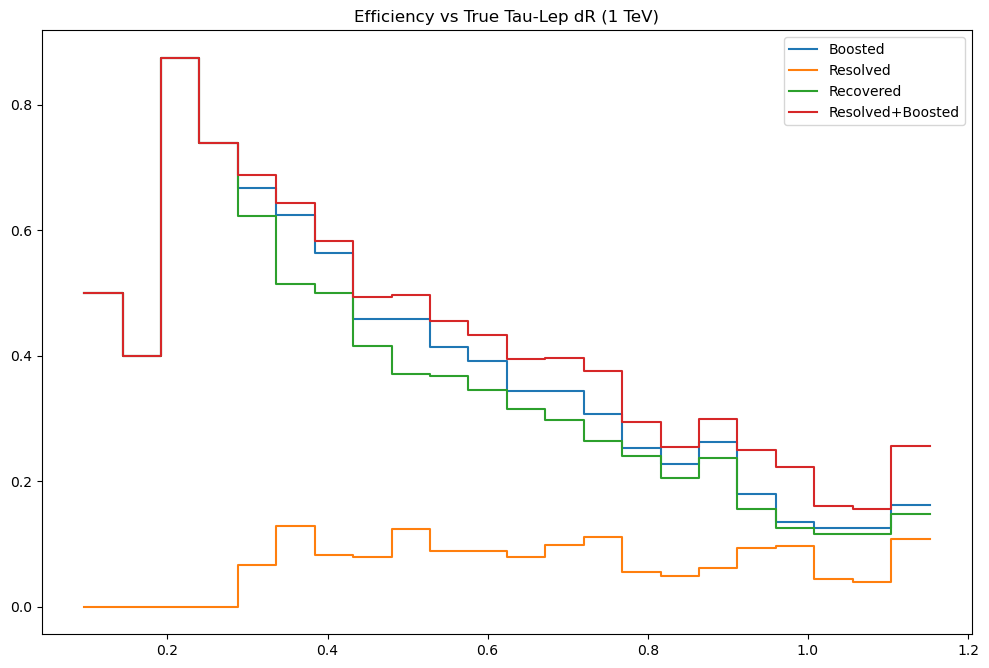

In [45]:
hadel_drs = np.array(sig10_sample.hadel_branches['TruthHadTauVisFinalLeptondR'])

boosted_branches = boosted_hadel_selection().apply_cuts_to_branches(sig10_sample.hadel_branches)
boosted_after_drs = np.array(boosted_branches['TruthHadTauVisFinalLeptondR'])
eff_from_drs(hadel_drs, boosted_after_drs, 'Boosted')

resolved_branches = resolved_hadel_selection().apply_cuts_to_branches(sig10_sample.hadel_branches)
resolved_after_drs = np.array(resolved_branches['TruthHadTauVisFinalLeptondR'])
eff_from_drs(hadel_drs, resolved_after_drs, 'Resolved')

failed_resolved_mask = ~resolved_hadel_selection().combined_cut_mask(sig10_sample.hadel_branches)
failed_resolved_branches = sig10_sample.hadel_branches[failed_resolved_mask]
recovered_branches = boosted_hadel_selection().apply_cuts_to_branches(failed_resolved_branches)
recovered_after_drs = np.array(recovered_branches['TruthHadTauVisFinalLeptondR'])
eff_from_drs(hadel_drs, recovered_after_drs, 'Recovered')

print(type(recovered_branches))
both_branches = ak.concatenate([recovered_branches, resolved_branches])
print(len(both_branches))
#both_branches = recovered_branches + resolved_hadel_selection().apply_cuts_to_branches(sig10_sample.hadel_branches)
both_before_drs = np.array(sig10_sample.hadel_branches['TruthHadTauVisFinalLeptondR'])  
both_after_drs = np.array(both_branches['TruthHadTauVisFinalLeptondR'])
eff_from_drs(both_before_drs, both_after_drs, 'Resolved+Boosted')

plt.title('Efficiency vs True Tau-Lep dR (1 TeV)') 
plt.legend()
plt.show()

## Channel selection

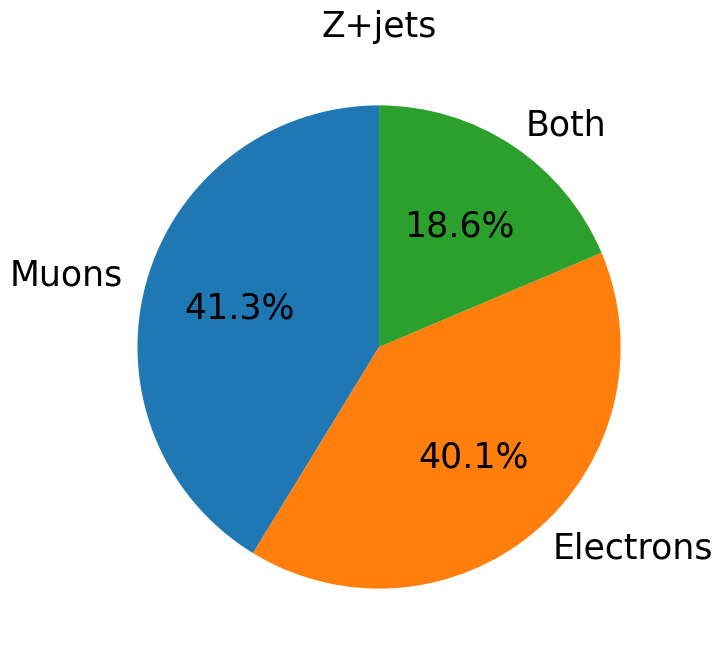

In [17]:
branches = zhf_sample.branches

only_tight_muon_branches = branches[ak.all([branches['HadElChosenElePt'] > 0, branches['HadMuChosenMuPt'] == 0], axis=0)]
only_loose_electron_branches = branches[ak.all([branches['HadElChosenElePt'] == 0, branches['HadMuChosenMuPt'] > 0], axis=0)]
both_branches = branches[ak.all([branches['HadElChosenElePt'] > 0, branches['HadMuChosenMuPt'] > 0], axis=0)]
both_system_mask = ak.all([branches['HadMuChosenMuPt'] > 0, branches['HadMuChosenTauPt'] > 0, branches['HadMuLargeRHbbJetPt'] > 0, branches['HadElChosenElePt'] > 0, branches['HadElChosenTauPt'] > 0, branches['HadElLargeRHbbJetPt'] > 0], axis=0)
# print(both_system_mask)
ele_system_branches = branches[ak.all([branches['HadElChosenElePt'] > 0, branches['HadElChosenTauPt'] > 0, branches['HadElLargeRHbbJetPt'] > 0], axis=0)]
mu_system_branches = branches[ak.all([branches['HadMuChosenMuPt'] > 0, branches['HadMuChosenTauPt'] > 0, branches['HadMuLargeRHbbJetPt'] > 0], axis=0)]
both_system_branches = branches[both_system_mask]
# print(both_system_branches)

nevents = len(branches)
nonly_mu = len(only_tight_muon_branches)
nonly_ele = len(only_loose_electron_branches)
nboth = len(both_branches)
nele_system = len(ele_system_branches)
nmu_system = len(mu_system_branches)
nboth_system = len(both_system_branches)
# print(nevents)
# print(nonly_mu)
# print(nonly_ele)
# print(nboth)
# print(nele_system)
# print(nmu_system)
# print(nele_system + nmu_system)
# print(nboth_system)

labels = ['Muons', 'Electrons', 'Both']
sizes = [nonly_mu, nonly_ele, nboth]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize':25}, startangle=90)
plt.title('Z+jets', size=25)
plt.show()

### HadMu

In [13]:
def hadmu_selection(sample):
    branches = sample.fid_branches
    
    min_pt_muons = [branches['LeadingMuTightPt'] > 20]
    
    only_tight_muon_defs = [branches['NMuTight'] > 0, branches['NEleLoose'] == 0]
    only_tight_muon_branches = branches[ak.all(only_tight_muon_defs, axis=0)]

    tight_muon_leading_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, branches['LeadingMuTightPt'] > branches['LeadingEleLoosePt']], axis=0)]
    
    branches_list = [only_tight_muon_branches, tight_muon_leading_branches]
    #branches_list = [only_tight_muon_branches]
    combined_muon_branches = ak.concatenate(branches_list)
    print(len(combined_muon_branches))
    
    channel_effs(sample, combined_muon_branches)

In [14]:
for sample in signal_samples:
    print(sample.short_name)
    hadmu_selection(sample)
    print('')

1 TeV
6809
Percentage of sample: 47.8%
Sample channel breakdown       HadEl: 6.2%  HadMu: 93.8%
Percentage of total hadel events: 5.7%
Percentage of total hadmu events: 93.3%

1.6 TeV
27348
Percentage of sample: 50.3%
Sample channel breakdown       HadEl: 7.0%  HadMu: 93.0%
Percentage of total hadel events: 7.1%
Percentage of total hadmu events: 93.0%

2 TeV
16220
Percentage of sample: 50.9%
Sample channel breakdown       HadEl: 8.7%  HadMu: 91.3%
Percentage of total hadel events: 8.9%
Percentage of total hadmu events: 91.9%



### HadEl

In [24]:
def hadel_selection(sample):
    branches = sample.branches
    
    only_loose_electron_branches = branches[ak.all([branches['NMuTight'] == 0, branches['NEleLoose'] > 0], axis=0)]
    #loose_electron_leading_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, 20 < branches['LeadingEleLoosePt']], axis=0)]
    multilep_branches = branches[ak.all([branches['NMuTight'] , branches['NEleLoose'] == 1], axis=0)]
    loose_electron_leading_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, branches['LeadingEleLoosePt'] > branches['LeadingMuTightPt']], axis=0)]
    
    electron_branches_list = [only_loose_electron_branches, loose_electron_leading_branches]
    #electron_branches_list = [only_loose_electron_branches]
    combined_electron_branches = ak.concatenate(electron_branches_list)
    
    channel_effs(sample, combined_electron_branches)
    print(len(loose_electron_leading_branches) / len(multilep_branches))

In [25]:
for sample in signal_samples:
    print(sample.short_name)
    hadel_selection(sample)
    print('')

1 TeV
Percentage of sample: 208.1%
Sample channel breakdown       HadEl: 96.3%  HadMu: 3.7%
Percentage of total hadel events: 385.6%
Percentage of total hadmu events: 16.2%
0.6084552568900987

1.6 TeV
Percentage of sample: 84.7%
Sample channel breakdown       HadEl: 95.4%  HadMu: 4.6%
Percentage of total hadel events: 162.4%
Percentage of total hadmu events: 7.8%
0.6137381522758046

2 TeV
Percentage of sample: 66.0%
Sample channel breakdown       HadEl: 94.2%  HadMu: 5.8%
Percentage of total hadel events: 125.7%
Percentage of total hadmu events: 7.5%
0.6514813989752729



In [9]:
sample = analysis_sig20_sample
branches = sample.fid_branches

In [10]:
leadingbtagjet_p4 = create_p4s_branch(branches, 'LeadingBTagJet')
leadingjet_p4 = create_p4s_branch(branches, 'LeadingJet')
leadinglargerjet_p4 = create_p4s_branch(branches, 'LeadingLargeRJet')
leadingmutight_p4 = create_p4s_branch(branches, 'LeadingMuTight')
leadingeleloose_p4 = create_p4s_branch(branches, 'LeadingEleLoose')
bjet_muon_dr = leadingbtagjet_p4.delta_r(leadingmutight_p4)
bjet_ele_dr = leadingbtagjet_p4.delta_r(leadingeleloose_p4)
jet_muon_dr = leadingjet_p4.delta_r(leadingmutight_p4)
jet_ele_dr = leadingjet_p4.delta_r(leadingeleloose_p4)
largerjet_muon_dr = leadinglargerjet_p4.delta_r(leadingmutight_p4)
largerjet_ele_dr = leadinglargerjet_p4.delta_r(leadingeleloose_p4)

In [ ]:
muon_btag_closer_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, bjet_muon_dr < bjet_ele_dr], axis=0)]
muon_jet_closer_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, jet_muon_dr < jet_ele_dr], axis=0)]
muon_largerjet_closer_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, largerjet_muon_dr < largerjet_ele_dr], axis=0)]
ele_leading_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0, branches['LeadingMuTightPt'] < branches['LeadingEleLoosePt']], axis=0)]
both_leps_branches = branches[ak.all([branches['NMuTight'] > 0, branches['NEleLoose'] > 0], axis=0)]

### dR to leading b-tag jet 

In [12]:
channel_effs(sample, muon_btag_closer_branches)

Percentage of sample: 19.7%
Sample channel breakdown       HadEl: 75.9%  HadMu: 24.1%
Percentage of total hadel events: 30.8%
Percentage of total hadmu events: 9.2%


In [13]:
channel_effs(sample, muon_jet_closer_branches)

Percentage of sample: 16.7%
Sample channel breakdown       HadEl: 77.5%  HadMu: 22.5%
Percentage of total hadel events: 26.7%
Percentage of total hadmu events: 7.3%


In [14]:
channel_effs(sample, muon_largerjet_closer_branches)

Percentage of sample: 18.9%
Sample channel breakdown       HadEl: 78.2%  HadMu: 21.8%
Percentage of total hadel events: 30.5%
Percentage of total hadmu events: 8.0%


In [185]:
channel_effs(sample, ele_leading_branches)

Percentage of sample: 19.7%
Sample channel breakdown       HadEl: 79.9%  HadMu: 20.1%
Percentage of total hadel events: 32.5%
Percentage of total hadmu events: 7.7%


In [207]:
three_leps_branches = branches[ak.all([branches['NMuTight'] + branches['NEleLoose'] > 2, ak.any([branches['NMuTight'] > 1, branches['NEleLoose'] > 1], axis=0)], axis=0)]

In [208]:
channel_effs(sample, three_leps_branches)

Percentage of sample: 14.5%
Sample channel breakdown       HadEl: 48.0%  HadMu: 52.0%
Percentage of total hadel events: 14.4%
Percentage of total hadmu events: 14.6%


In [48]:
def elmu_compare_hists(branches, branch_name, bins, min_val, max_val):
    hadel_branches = branches[branches['PDGTruthMatchType'] == 2]
    hadmu_branches = branches[branches['PDGTruthMatchType'] == 3]
    
    create_normed_hist(hadel_branches[branch_name], bins, min_val, max_val, 'HadEl')
    create_normed_hist(hadmu_branches[branch_name], bins, min_val, max_val, 'HadMu')
    plt.title(branch_name)
    plt.yscale('log')
    plt.legend()
    plt.show()
    
def elmu_compare_2dhist(branches, first_branch_name, second_branch_name, bins, min_val, max_val):
    hadel_branches = branches[branches['PDGTruthMatchType'] == 2]
    hadmu_branches = branches[branches['PDGTruthMatchType'] == 3]
    
    plt.hist2d(np.array(hadel_branches[first_branch_name]), np.array(hadel_branches[second_branch_name]), bins, [[min_val, max_val], [min_val, max_val]], alpha=0.5, cmap='Blues')
    plt.hist2d(np.array(hadmu_branches[first_branch_name]), np.array(hadmu_branches[second_branch_name]), bins, [[min_val, max_val], [min_val, max_val]], alpha=0.5, cmap='Reds')
    plt.xlabel(first_branch_name)
    plt.ylabel(second_branch_name)
    plt.show()

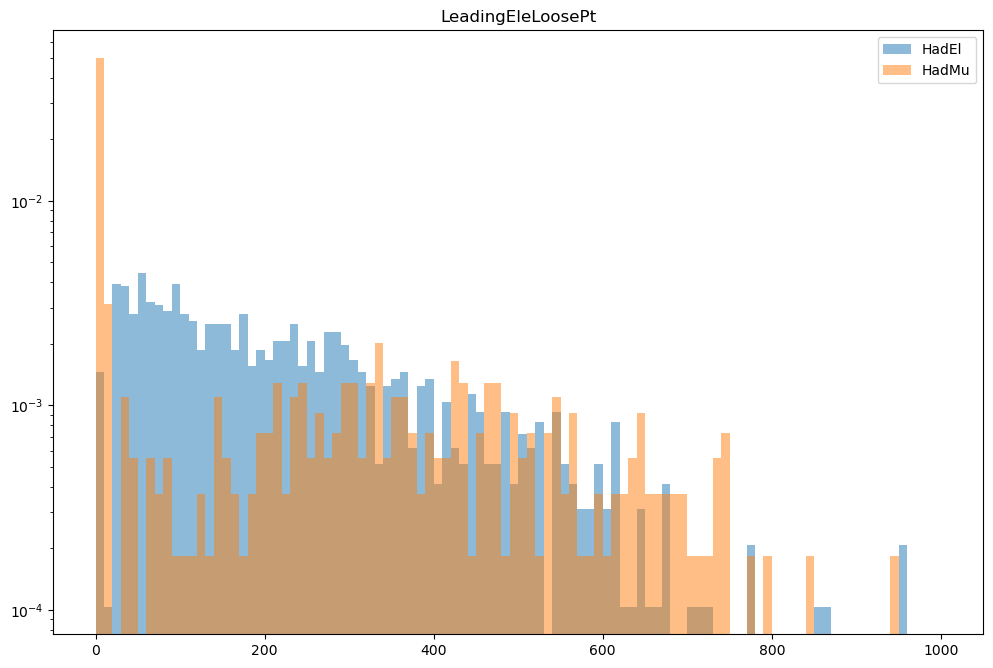

In [50]:
elmu_compare_hists(both_leps_branches, 'LeadingEleLoosePt', 100, 0, 1000)

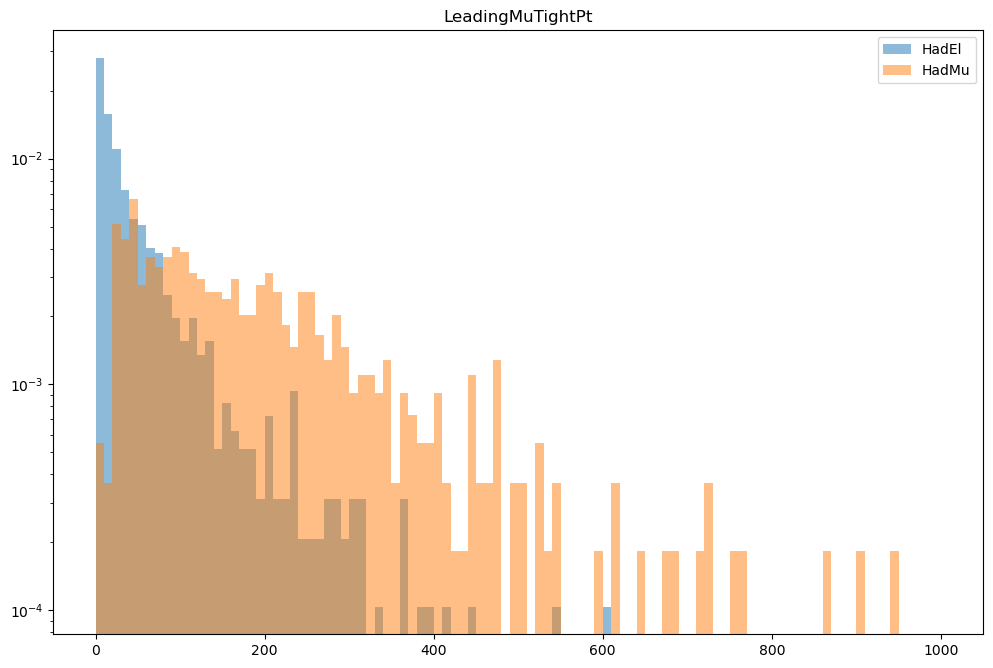

In [52]:
elmu_compare_hists(both_leps_branches, 'LeadingMuTightPt', 100, 0, 1000)

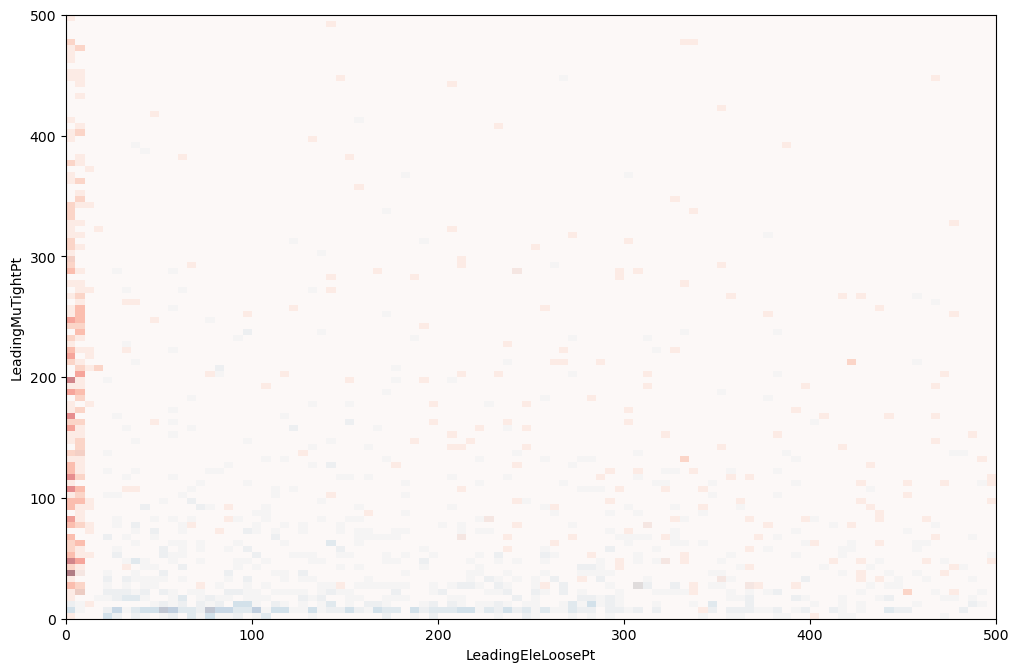

In [299]:
elmu_compare_2dhist(both_leps_branches, 'LeadingEleLoosePt', 'LeadingMuTightPt', 100, 0, 500)

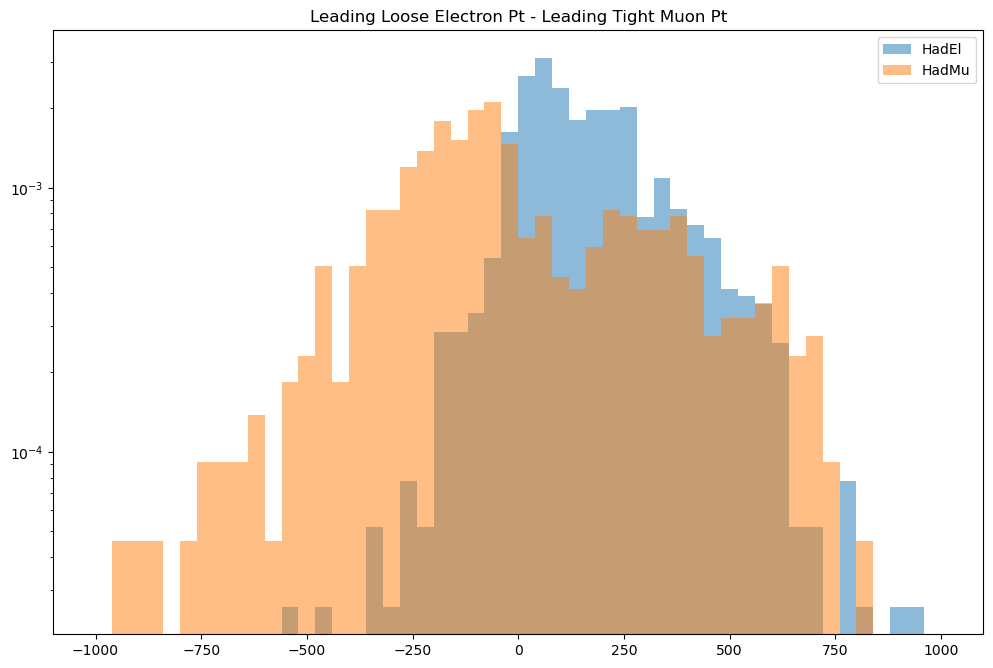

In [38]:
bins=50
min_val = -1000
max_val = 1000
hadel_branches = both_leps_branches[both_leps_branches['PDGTruthMatchType'] == 2]
hadmu_branches = both_leps_branches[both_leps_branches['PDGTruthMatchType'] == 3]

create_normed_hist(hadel_branches['LeadingEleLoosePt'] - hadel_branches['LeadingMuTightPt'], bins, min_val, max_val, 'HadEl')
create_normed_hist(hadmu_branches['LeadingEleLoosePt'] - hadmu_branches['LeadingMuTightPt'], bins, min_val, max_val, 'HadMu')
plt.title('Leading Loose Electron Pt - Leading Tight Muon Pt')
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
branches = sig10_sample.branches
print(len(branches))
both_lepton_mask = ak.all([branches['LeadingEleLoosePt'] > 0, branches['LeadingMuTightPt'] > 0], axis=0)
print(both_lepton_mask)
branches = branches[both_lepton_mask]
print(len(branches))
leading_electron_mask = branches['LeadingEleLoosePt'] >= branches['LeadingMuTightPt']
truth_electron_mask = branches['PDGTruthMatchType'] == 2
correct_electron_mask = ak.all([leading_electron_mask, truth_electron_mask], axis=0)
leading_muon_mask = branches['LeadingEleLoosePt'] < branches['LeadingMuTightPt']
truth_muon_mask = branches['PDGTruthMatchType'] == 3
correct_muon_mask = ak.all([leading_muon_mask, truth_muon_mask], axis=0)
correct_electron_events = sum(correct_electron_mask)
correct_muon_events = sum(correct_muon_mask)
print((correct_electron_events + correct_muon_events) / len(branches))

72278
[False, False, False, False, True, False, ... False, False, False, False, True]
17705
0.7955379836204463


(array([ 1.,  7., 11.,  6., 11., 14., 15., 20., 18., 19.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 ], dtype=float32),
 <BarContainer object of 10 artists>)

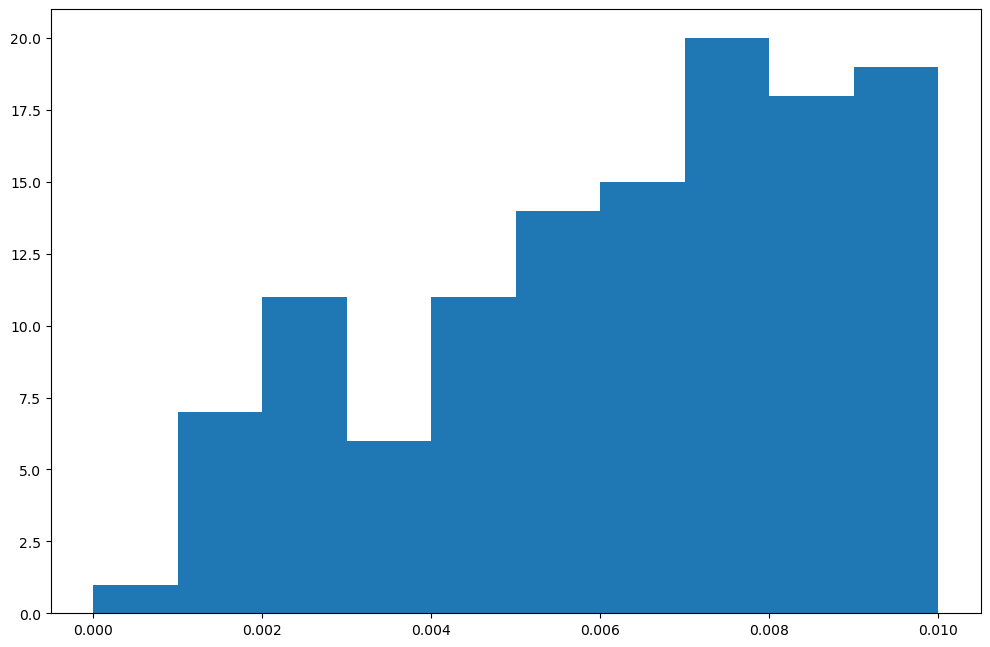

In [10]:
branches = sig10_sample.fid_branches
branches = branches[branches['HadElChosenElePt'] > 0]

plt.hist(branches['HadElChosenTauEledR'], range=(0, .01))